# Import Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import re
import missingno as msno
import datetime as dt
import chart_studio.plotly as py
import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

# Make Plotly work in your Jupyter Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
# Use Plotly locally
cf.go_offline()

import warnings
warnings.filterwarnings('ignore')

Load Data

In [5]:
sel = pd.read_csv('sel new.csv')

# Drop Duplicate information in the dataset
sel.drop_duplicates(subset ='LoanId', keep = 'first', inplace = True)

#filter out written off accounts from analysis, this is to ensure we dont include customers who have written off accounts in our analysis no matter how profitable they were before their last loan which was written off
off = sel[(sel['AccountState'].isin(['CLOSED_WRITTEN_OFF']))]
#get the client ids for written off accounts
off = off.clientID
  #get clientID in written off accounts that are in this data
common_id =set(off).intersection(set(sel.clientID))
  #remove the common clientID in  data
sel = sel.drop(sel[sel['clientID'].isin(common_id)].index)



In [6]:
#age groups
#bin age 

cut_labels_4 = ['20-25', '25-30', '30-35','35-40', '40-45', '45-50', 'above 50']
cut_bins = [20, 25, 30, 35, 40, 45, 50, 60]

#sel loan
sel['AgeGroup']= pd.cut(sel['Age'], bins=cut_bins, labels=cut_labels_4)

# RFM

For successfulyy closed accounts, we can get the profit made by the company uner InterestPaid field, we can't get the monetary value for active and active in arrears accounts while closed_written off accounts are the least valuable accounts

## Recency

Recency is the last time a customer applied for a loan

In [7]:
#client id of customers that have been disbursed to
Sel = sel[~(sel['DisbMonth'].isna())]
Sel = Sel[Sel['Closeddate']<='2021-09-30']
ids = Sel.groupby('clientID').size().reset_index(name='count')
ids = ids.clientID.values
len(ids)


1860

we have 1860 unique ciustomers in sel Loans from feb - sept

In [8]:
#to get their recency value, we need to look for these ids in the main application data and checkc the last time each of the customer interacted with the system

recency_sel = sel[sel['clientID'].isin(ids)]
recency_sel = recency_sel[recency_sel['Closeddate']<='2021-09-30']
recency_sel.shape

(7104, 38)

In [9]:
recency_sel['Closeddate'] = pd.to_datetime(recency_sel['Closeddate'])

In [10]:
recency = recency_sel.filter(['clientID', 'Closeddate'])
recency = recency.groupby('clientID').Closeddate.max().reset_index(name='Last Seen Date')
recency.head()

clientID Last Seen Date
0  22141758194     2021-07-19
1  22141758686     2021-04-13
2  22141800143     2021-09-06
3  22141881355     2021-07-11
4  22141882864     2021-04-16

Recency= all the account states
frequency =

In [11]:
# since recency is the interval between the last day a customer interacted with the system and today, lets get the difference in days

import datetime 

recency['Recency'] = datetime.datetime(2021, 9, 30) -recency['Last Seen Date']
recency['Recency'] = recency['Recency'].dt.days
recency.head()

clientID Last Seen Date  Recency
0  22141758194     2021-07-19       73
1  22141758686     2021-04-13      170
2  22141800143     2021-09-06       24
3  22141881355     2021-07-11       81
4  22141882864     2021-04-16      167

In [12]:
#get active and active in arrears customers
act = sel[sel['AccountState'].isin(['ACTIVE', 'ACTIVE_IN_ARREARS'])]
act_id  = act.clientID
rec = recency.clientID

#find loanid common to both datasets
active_id = list(set(act_id).intersection(set(rec)))


recency['Recency1']= np.where(recency['clientID'].isin(act_id.values), 0, recency['Recency'])
recency.head(10)

clientID Last Seen Date  Recency  Recency1
0  22141758194     2021-07-19       73         0
1  22141758686     2021-04-13      170       170
2  22141800143     2021-09-06       24        24
3  22141881355     2021-07-11       81         0
4  22141882864     2021-04-16      167       167
5  22141906476     2021-08-22       39        39
6  22141943983     2021-08-06       55        55
7  22141957171     2021-09-28        2         2
8  22141975667     2021-06-16      106       106
9  22141975874     2021-08-15       46         0

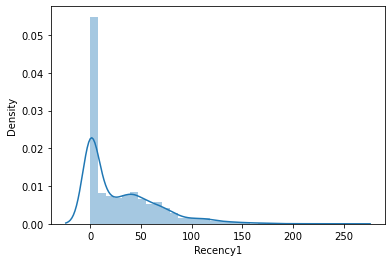

In [13]:
# Recency distribution plot

x = recency['Recency1']

ax = sns.distplot(x)


In [14]:
recency.shape

(1860, 4)

## Age T of Customers
which is the current date we are using - the first time customer took a loan

In [15]:


#get data
age = recency_sel.filter(['clientID', 'DisbursementDate'])
age['DisbursementDate'] = pd.to_datetime(age['DisbursementDate'])
age = age.groupby('clientID').DisbursementDate.min().reset_index(name='First purchase Date')
age.head()

clientID First purchase Date
0  22141758194          2021-05-05
1  22141758686          2021-01-26
2  22141800143          2021-06-10
3  22141881355          2021-03-10
4  22141882864          2021-03-12

In [16]:
import datetime 

age['T'] = datetime.datetime(2021, 9, 30) -age['First purchase Date']
age['T'] = age['T'].dt.days
age.head()

clientID First purchase Date    T
0  22141758194          2021-05-05  148
1  22141758686          2021-01-26  247
2  22141800143          2021-06-10  112
3  22141881355          2021-03-10  204
4  22141882864          2021-03-12  202

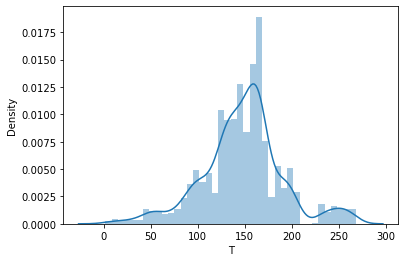

In [17]:
# Recency distribution plot

x = age['T']

ax = sns.distplot(x)


## Frequency

In [18]:
#
recency_sel =recency_sel[~(recency_sel['DisbMonth'].isna())]
recency_sel = recency_sel[recency_sel['Closeddate']<='2021-09-30']
frequency = recency_sel.filter(['clientID', 'LoanId'])

#frequency= frequency[frequency['AccountState'].isin(['CLOSED'])]
#frequency = frequency[frequency['AccountSubstate'].isna()]
#where active, closed, active_in_arrears
frequency = frequency.groupby('clientID').LoanId.count().reset_index(name='Frequency')
frequency.Frequency.head()

0    1
1    1
2    1
3    1
4    1
Name: Frequency, dtype: int64

In [19]:
frequency.Frequency.max()

5

In [20]:
frequency.Frequency.value_counts()

1    1800
2      55
3       4
5       1
Name: Frequency, dtype: int64

## Monetary

### factoring Unit Economics

### add the monetary fields: get the total amount paid by customer and deduct loan amount

In [21]:
#MONETARY; only closed accounts
Sel =sel[sel['AccountState']=='CLOSED']
Sel = Sel[~(Sel['DisbMonth'].isna())]
Sel = Sel[Sel['Closeddate']<='2021-09-30']

#confirm loan amount is equiavalent to principalpaid
Sel['LoanAmount'].equals(other= Sel['principalpaid'])


True

since it's equal, we dont need to include loan amount 

In [22]:


monetary = Sel[['clientID', 'LoanId','LoanType', 'principalpaid', 'interestpaid', 'feespaid', 'penaltypaid']]
# remove the ids so it wont add to the monetary we are trying to calculate
cols = list(monetary)
cols.remove('clientID')
cols.remove('LoanId')
#get row wise sum
monetary['total'] = monetary[cols].sum(numeric_only = True, axis=1)
# since we added all monetary vlues, let;s subtract the principal which is equivalent to loan amount
monetary['money'] =monetary['total'] - monetary['principalpaid']
# cost of servicing loan accounts of 5 -9k is 737 and of 10-20k 103

monetary['Unit Economics'] = np.where(
  # for New :
    #for Loan amount less than 50k
    (monetary['principalpaid'] < 50000) & (monetary['LoanType']=='New'),1775 , 
    # for Loan amount less than 125k
    np.where(
    (monetary['principalpaid'] < 125000) & (monetary['LoanType']=='New'), 3481, 
    # for Loanamount up to 200k
    np.where(
    (monetary['principalpaid'] >= 125000) & (monetary['LoanType']=='New'), 7778,
    
  # for Growth :
    #for   20-99k
    np.where(
    (monetary['principalpaid'] < 100000) & (monetary['LoanType']=='Renewal'), 2962 , 
    # for Loan amount less than 250k
    np.where(
    (monetary['principalpaid'] < 250000) & (monetary['LoanType']=='Renewal'),  6966, 
    # for Loanamount up to 750k
    np.where(
    (monetary['principalpaid'] < 750000) & (monetary['LoanType']=='Renewal'), 16937,
    # for Loanamount up to 1m
    np.where(
    (monetary['principalpaid'] >=750000) & (monetary['LoanType']=='Renewal'), 63195,


  # for Seasoned :
    #for   20-199k
    np.where(
    (monetary['principalpaid'] < 200000) & (monetary['LoanType']=='Top Up'), 6584 , 
    # for Loan amount less than 250k
    np.where(
    (monetary['principalpaid'] < 350000) & (monetary['LoanType']=='Top Up'),  15817, 
    # for Loanamount up to 750k
    np.where(
    (monetary['principalpaid'] < 800000) & (monetary['LoanType']=='Top Up'), 38546,
    # for Loanamount up to 750k
    np.where(
    (monetary['principalpaid'] >= 800000) & (monetary['LoanType']=='Top Up'), 146991 , monetary['principalpaid'] )))))))))))
  

monetary['Monetary'] = monetary['money'] - monetary['Unit Economics']
monetary = monetary.groupby('clientID').agg({'Monetary': 'sum'}).reset_index()
monetary.shape
monetary.head()

clientID   Monetary
0  22141758194   62939.72
1  22141758686  264846.14
2  22141800143   14131.34
3  22141881355   62916.94
4  22141882864    8523.51

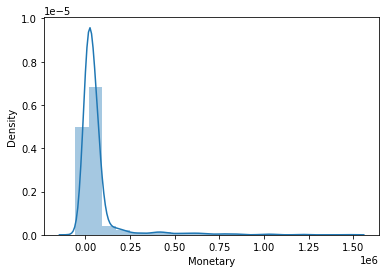

In [23]:
# Monetary distribution plot, taking observations which have monetary value less than 10000

x = monetary['Monetary']

ax = sns.distplot(x, bins=20)

<AxesSubplot:xlabel='Monetary'>

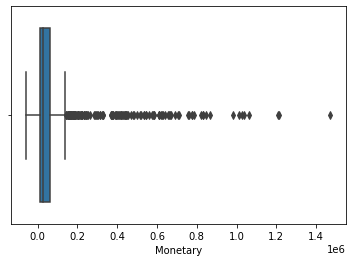

In [24]:
sns.boxplot(monetary['Monetary'])

#### check our most frequent customer

In [27]:
#Merging three dataframes to create rfm tabley


rfm_table = pd.merge(pd.merge(recency[['clientID', 'Recency1']], frequency[['clientID', 'Frequency']], on='clientID'), pd.merge(monetary[['clientID', 'Monetary']], age[['clientID', 'T']] ,on='clientID'), on='clientID')
rfm_table.rename(columns={'Recency1': 'Recency'}, inplace=True)
rfm_table.head()

clientID  Recency  Frequency   Monetary    T
0  22141758194        0          1   62939.72  148
1  22141758686      170          1  264846.14  247
2  22141800143       24          1   14131.34  112
3  22141881355        0          1   62916.94  204
4  22141882864      167          1    8523.51  202

count    1795.000000
mean        1.037326
std         0.217028
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         5.000000
Name: Frequency, dtype: float64
---------------------------------------
Percentage of customers that requested for Loan only once: 96.66 %


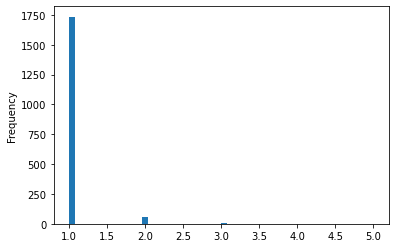

In [28]:
%matplotlib inline
#Create histogram to find out how many customers purchased item only once.
rfm_table['Frequency'].plot(kind='hist', bins=50)
print(rfm_table['Frequency'].describe())
print("---------------------------------------")
one_time_buyers = round(sum(rfm_table['Frequency'] == 1)/float(len(rfm_table))*(100),2)
print("Percentage of customers that requested for Loan only once:", one_time_buyers ,"%")

In [29]:
#Shortlist customers who had at least one repeat purchase with the company. 
shortlisted_customers = rfm_table[rfm_table['Frequency']>1]
print(shortlisted_customers.head().reset_index())
print("-----------------------------------------")
print("The Number of Returning Customers are: ",len(shortlisted_customers))

   index     clientID  Recency  Frequency   Monetary    T
0     18  22142430569        0          2  205285.11  240
1     58  22143603267        8          2  374189.67  126
2    139  22146600432        1          2   38761.80  169
3    166  22147546654        0          2   59781.54  194
4    173  22147834265        0          2  154047.60  202
-----------------------------------------
The Number of Returning Customers are:  60


In [28]:
#Shortlist customers who had at least one repeat purchase with the company. 
shortlisted_customers = rfm_table[rfm_table['Frequency']==1]
print(shortlisted_customers.head().reset_index())
print("-----------------------------------------")
print("The Number of One time buyer Customers are: ",len(shortlisted_customers))

   index     clientID  Recency  Frequency   Monetary    T
0      0  22141758194        0          1   69683.72  148
1      1  22141758686      170          1  327007.14  247
2      2  22141800143       24          1   14872.34  112
3      3  22141881355        0          1   69660.94  204
4      4  22141882864      167          1    9264.51  202
-----------------------------------------
The Number of One time buyer Customers are:  1735


## RFM using Clusters

### some ML functions

In [142]:
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn import preprocessing

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [152]:
rfm_table.Monetary.max()

31099.339999999997

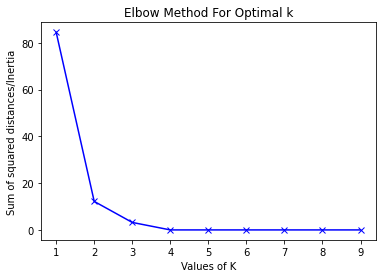

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
Sum_of_squared_distances=[]
K = range(1,10)

for num_clusters in range(1, 10) :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(rfm_table[['Frequency']])
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [37]:
KMean= KMeans(n_clusters=3)
KMean.fit(rfm_table)
label=KMean.predict(rfm_table)

print(f'Silhouette Score: {silhouette_score(rfm_table, label)}')

Silhouette Score: 0.5960544525945183


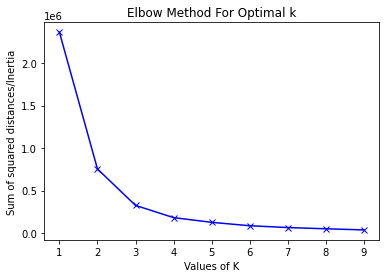

In [38]:
Sum_of_squared_distances=[]
K = range(1,10)

for num_clusters in range(1, 10) :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(rfm_table[['Recency']])
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

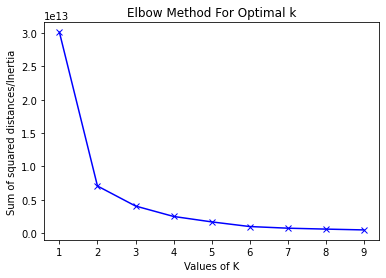

In [39]:
Sum_of_squared_distances=[]
K = range(1,10)

for num_clusters in range(1, 10) :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(rfm_table[['Monetary']])
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

First, we decide on the optimum no of clusters. Here, we get 3 as optimum no of clusters which means there will be three cuts for recency, frequency, and monetary each. This is done using the K-means clustering algorithm

In [40]:
#Finding Optimum Clusters

#### Function for ordering clusters
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_'+cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending = ascending).reset_index(drop=True)
    df_new['index']=df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final
  
#Recency Clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(rfm_table[['Recency']])
rfm_table['RecencyCluster']=kmeans.predict(rfm_table[['Recency']])
rfm_table = order_cluster('RecencyCluster','Recency', rfm_table, False)

#Frequency Clusters
kmeans = KMeans(n_clusters=2)
kmeans.fit(rfm_table[['Frequency']])
rfm_table['FrequencyCluster']=kmeans.predict(rfm_table[['Frequency']])
rfm_table = order_cluster('FrequencyCluster','Frequency', rfm_table, True)

#Monetary Clusters
kmeans = KMeans(n_clusters=2)
kmeans.fit(rfm_table[['Monetary']])
rfm_table['MonetaryCluster']=kmeans.predict(rfm_table[['Monetary']])
rfm_table = order_cluster('MonetaryCluster','Monetary', rfm_table, True)

# Define a function to map the values 
def set_value(row_number, assigned_value): 
    return assigned_value[row_number] 
  
# Creating Recency Custer Tag Column
c=rfm_table.groupby('RecencyCluster')['Recency'].agg(['min','max','mean']).reset_index()
r1='<='+str(c.iloc[3,2]) 
r2=str(c.iloc[2,1])+' to '+str(c.iloc[2,2]) 
r3=str(c.iloc[1,1])+' to '+str(c.iloc[1,2]) 
r4='>='+str(c.iloc[0,1])
#Create the dictionary 
R ={0 : r4, 1 : r3, 2 : r2, 3:r1} 
rfm_table['RecencyClusterTag']=rfm_table['RecencyCluster'].apply(set_value, args =(R, )) 

# Creating Frequency Custer Tag Column
a=rfm_table.groupby('FrequencyCluster')['Frequency'].agg(['min','max','mean']).reset_index()
f1='>1' 
f4='1'
#Create the dictionary 
F ={0 : f4, 1 : f1} 
rfm_table['FrequencyClusterTag']=rfm_table['FrequencyCluster'].apply(set_value, args =(F, )) 

# Creating Monetary Custer Tag Column
b=rfm_table.groupby('MonetaryCluster')['Monetary'].agg(['min','max','mean']).reset_index()
m1='<='+str(b.iloc[1,1]) 
m4='>='+str(b.iloc[0,1])
#Create the dictionary 
M ={0 : m4, 1 : m1} 
rfm_table['MonetaryClusterTag']=rfm_table['MonetaryCluster'].apply(set_value, args =(M, )) 

rfm_table["FrequencyClusterTag"] = rfm_table["FrequencyClusterTag"].astype(pd.api.types.CategoricalDtype(categories=[f1, f4]))
rfm_table["MonetaryClusterTag"] = rfm_table["MonetaryClusterTag"].astype(pd.api.types.CategoricalDtype(categories=[m1, m4]))
rfm_table["RecencyClusterTag"] = rfm_table["RecencyClusterTag"].astype(pd.api.types.CategoricalDtype(categories=[r1, r2,r3, r4]))



In [41]:
c

RecencyCluster  min  max        mean
0               0   99  252  126.704762
1               1   55   98   70.727273
2               2   21   54   37.793407
3               3    0   20    3.284790

In [42]:
b

MonetaryCluster        min         max           mean
0                0  -58909.34   323370.40   38450.632352
1                1  329321.22  1471574.43  612193.896575

In [43]:
a

FrequencyCluster  min  max      mean
0                 0    1    1  1.000000
1                 1    2    5  2.116667

In [65]:
rfm_table.FrequencyCluster.value_counts()

0    1735
1      55
2       4
3       1
Name: FrequencyCluster, dtype: int64

### Data visualizations after deciding RFM clusters


<AxesSubplot:xlabel='RecencyClusterTag', ylabel='count'>

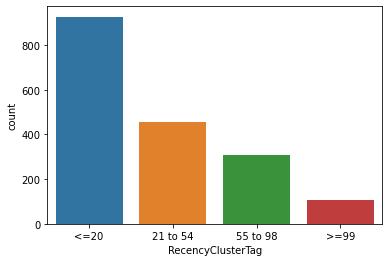

In [44]:
sns.countplot(x=rfm_table['RecencyClusterTag'])

<AxesSubplot:xlabel='FrequencyClusterTag', ylabel='count'>

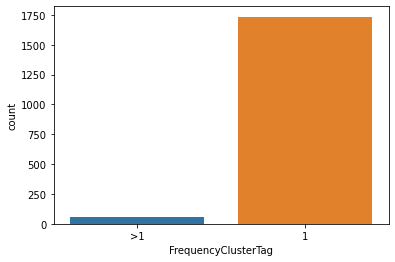

In [84]:
sns.countplot(x=rfm_table['FrequencyClusterTag'])

<AxesSubplot:xlabel='MonetaryClusterTag', ylabel='count'>

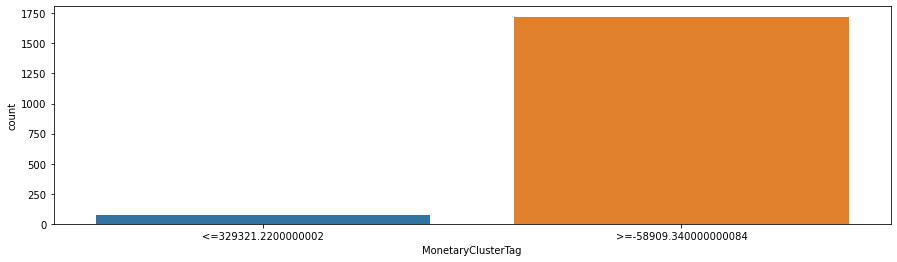

In [45]:
fig, ax = plt.subplots( figsize = (15,4))
sns.countplot(x=rfm_table['MonetaryClusterTag'])

Clustering doesn't seem to be the best case scenario for the product. Let's use quartile binning instead

## RFM using quartile binning

In [46]:
rfm = rfm_table[['clientID', 'Recency', 'Frequency', 'Monetary']]



#Split into four segments using quantiles
quantiles = rfm.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
#Functions to create R, F and M segments
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

#Calculate Add R, F and M segment value columns in the existing dataset to show R, F and M segment values

rfm['R'] = rfm['Recency'].apply(RScoring, args=('Recency',quantiles,))
rfm['F'] = rfm['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
rfm['M'] = rfm['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))

#Calculate and Add RFMGroup value column showing combined concatenated score of RFM
rfm['RFMGroup'] = rfm.R.map(str) + rfm.F.map(str) + rfm.M.map(str)

#Calculate and Add RFMScore value column showing total sum of RFMGroup values
rfm['RFMScore'] = rfm[['R', 'F', 'M']].sum(axis = 1)

#Assign Loyalty Level to each customer
Loyalty_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(rfm.RFMScore, q = 4, labels = Loyalty_Level)
rfm['RFM_Loyalty_Level'] = Score_cuts.values
rfm.reset_index().head()
rfm.head()

clientID  Recency  Frequency   Monetary  R  F  M RFMGroup  RFMScore  \
0  22141758194        0          1   62939.72  1  4  1      141         6   
1  22141881355        0          1   62916.94  1  4  2      142         7   
2  22141957171        2          1   17287.33  2  4  3      243         9   
3  22141975874        0          1  222936.72  1  4  1      141         6   
4  22142101256        0          1   82214.95  1  4  1      141         6   

  RFM_Loyalty_Level  
0          Platinum  
1          Platinum  
2              Gold  
3          Platinum  
4          Platinum

In [48]:
import chart_studio as cs
import plotly.offline as po
import plotly.graph_objs as gobj

#Recency Vs Frequency
graph = rfm

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Frequency'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['Frequency'],
        mode='markers',
        name='Silver', 
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['Frequency'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Frequency'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Loyalty Levels'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)

#Frequency Vs Monetary

graph = rfm

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Monetary'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['Monetary'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['Monetary'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Frequency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Monetary'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Monetary"},
        xaxis= {'title': "Frequency"},
        title='Loyalty Levels'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)


#Recency Vs Monetary
graph = rfm

plot_data = [
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Bronze'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Bronze'")['Monetary'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Silver'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Silver'")['Monetary'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Gold'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Gold'")['Monetary'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("RFM_Loyalty_Level == 'Platinum'")['Recency'],
        y=graph.query("RFM_Loyalty_Level == 'Platinum'")['Monetary'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Monetary"},
        xaxis= {'title': "Recency"},
        title='Loyalty Levels'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)


#make individuals plots for loyalty levels
# to get perfectcat of the levels, do a boxplot and see the spread



In [65]:
rfm[rfm['RFMGroup']=='214']

clientID  Recency  Frequency  Monetary  R  F  M RFMGroup  RFMScore  \
1704  22285804467       12          2  10130.64  2  1  4      214         7   
1706  22307138314        7          2  10374.88  2  1  4      214         7   

     RFM_Loyalty_Level         Segment  
1704          Platinum  About to Churn  
1706          Platinum  About to Churn

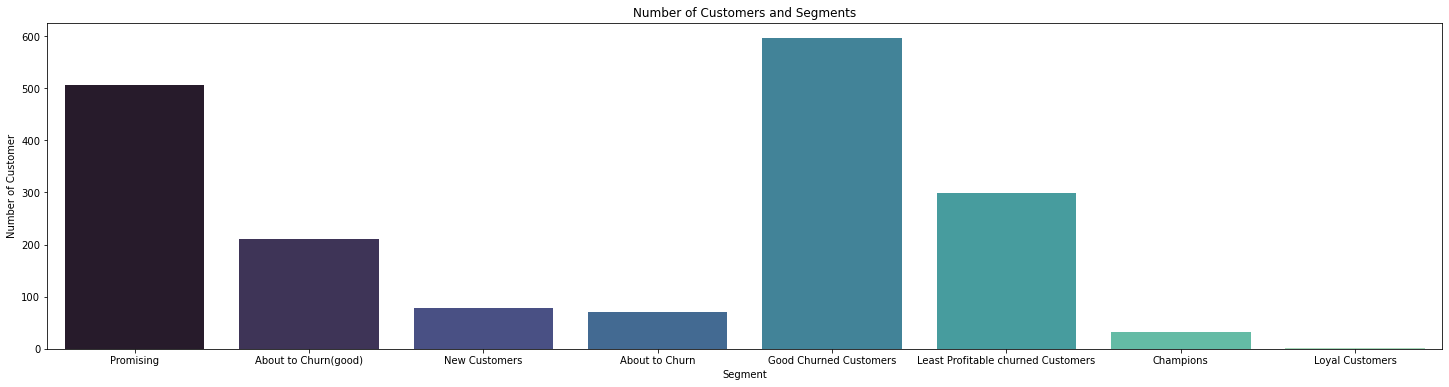

In [67]:
# Create human friendly RFM labels
segt_map = {
    r'11[1-2]': 'Champions',
      r'14[4]': 'New Customers',
      r'14[1-3]': 'Promising',
      r'11[3-4]': 'Loyal Customers',
      r'2[1-4][1-3]': 'About to Churn(good)',
      r'2[1-4][4]': 'About to Churn',
      r'[3-4][1-4][1-3]': 'Good Churned Customers',
      r'[3-4][1-4]4': 'Least Profitable churned Customers'

}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)


plt.figure(figsize=(25,6))
sns.countplot(x=rfm['Segment'], palette = 'mako')
plt.title('Number of Customers and Segments')
plt.xlabel('Segment')
plt.ylabel('Number of Customer')
plt.show()

In [66]:
rfm.RFMGroup.value_counts()

142    224
344    158
141    157
444    140
343    125
143    125
443    122
342    113
442    104
441     82
144     79
242     73
243     71
244     69
241     48
341     45
111     23
211     11
112      9
311      4
213      4
212      3
113      2
214      2
314      1
411      1
Name: RFMGroup, dtype: int64

In [53]:
rfm_table.RecencyClusterTag.value_counts()

<=20        927
21 to 54    455
55 to 98    308
>=99        105
Name: RecencyClusterTag, dtype: int64

In [57]:
# Create some simple functions we'll be using to create our summary dataframe

def groupby_mean(x):
    return x.mean()

def groupby_count(x):
    return x.count()

def groupby_sum(x):
    return x.sum()

def percentage(x):
    return round(((x.sum()/ 110902143.359)*100),1)

def avg_frequency(x):
    '''returns the average days between sales'''
    return (x.max() - x.min()).days/x.count()

groupby_mean.__name__ = 'avg'
groupby_count.__name__ = 'count'
groupby_sum.__name__ = 'sum'
avg_frequency.__name__ = 'purchase_frequency'

summary_df = rfm.groupby('RFM_Loyalty_Level').agg({
    'clientID': [ groupby_count],
    'Recency': [ groupby_mean],
    'Frequency': [groupby_mean],
    'Monetary' : [percentage, groupby_mean]
})

summary_df=summary_df.reset_index()
summary_df

RFM_Loyalty_Level clientID    Recency Frequency   Monetary               
                       count        avg       avg percentage            avg
0          Platinum      488   1.688525  1.135246       57.2  129927.575082
1              Gold      589  23.748727  1.001698       32.7   61519.196774
2            Silver      298  43.778523  1.000000        6.4   23910.909597
3            Bronze      420  65.407143  1.000000        3.7    9850.544667

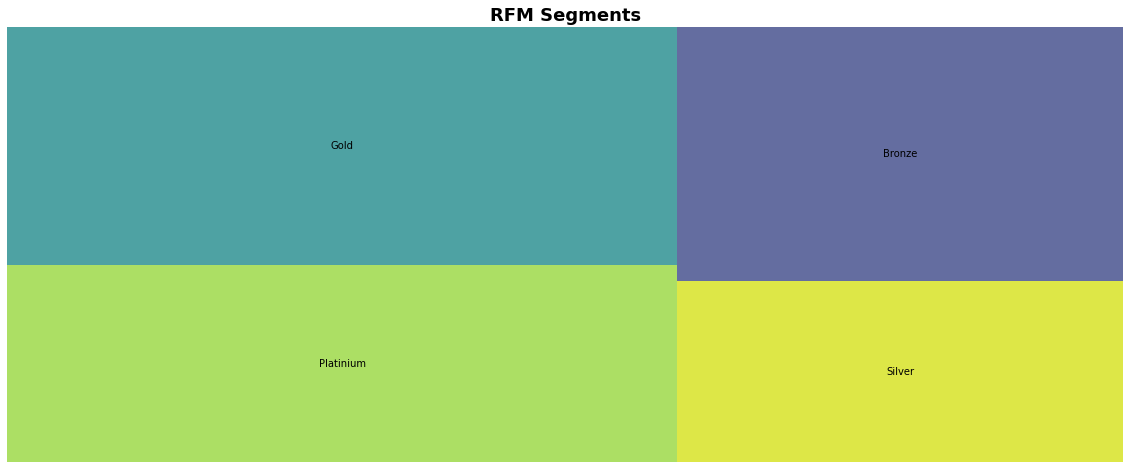

In [58]:
# Dropping a level down
summary_df.columns = summary_df.columns.droplevel(0)
summary_df

import squarify


# monetary values of each of the segments
#Create our RFM Segment plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(20, 8)
squarify.plot(sizes=summary_df['count'], 
              label=['Platinium',
                     'Gold',
                     'Silver',
                     'Bronze'], alpha=0.8 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

In [68]:
summary_df = rfm.groupby('Segment').agg({
    'clientID': [ groupby_count],
    'Recency': [ groupby_mean],
    'Frequency': [groupby_mean],
    'Monetary' : [percentage, groupby_mean]
})

summary_df=summary_df.reset_index()
summary_df

Segment clientID    Recency Frequency  \
                                         count        avg       avg   
0                      About to Churn       71   9.802817  1.028169   
1                About to Churn(good)      210   8.666667  1.090476   
2                           Champions       32   0.000000  2.093750   
3              Good Churned Customers      596  58.541946  1.013423   
4  Least Profitable churned Customers      299  59.939799  1.003344   
5                     Loyal Customers        2   0.000000  2.000000   
6                       New Customers       79   0.000000  1.000000   
7                           Promising      506   0.000000  1.000000   

    Monetary                 
  percentage            avg  
0        0.5    7338.593239  
1       14.8   78349.039429  
2        6.8  234408.360625  
3       34.6   64413.878842  
4        1.8    6634.360167  
5        0.0   17601.175000  
6        0.5    7002.645063  
7       41.0   89849.764091

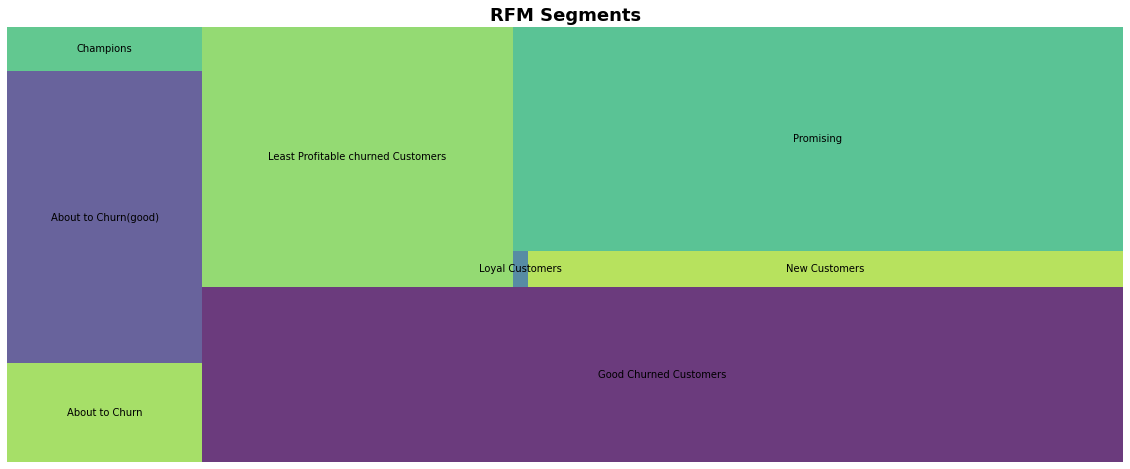

In [63]:
#Dropping a level down
summary_df.columns = summary_df.columns.droplevel(0)
summary_df



# monetary values of each of the segments
#Create our RFM Segment plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(20, 8)
squarify.plot(sizes=summary_df['count'], 
              label=summary_df[''].values, alpha=0.8 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

In [160]:
#let's merge this rfm dataframe with app data

rfm = rfm[['clientID', 'Recency', 'Frequency', 'Monetary']]

Sel = sel.merge(rfm, on='clientID')
Sel = Sel[Sel['AccountState']=='CLOSED']
Sel = Sel[~(Sel['DisbMonth'].isna())]
Sel = Sel.drop_duplicates('clientID', keep='first')
Sel.to_csv('sele&rfm.csv')

# RFM function


In [109]:
def RFM(data,  duration):
  '''
  A function that gets the Recency, Frequency and Monetary values based on timeframe specified and get labels based on quantile binning

  '''
  #client id of customers that have been disbursed to
  Data = data[~(data['DisbMonth'].isna())]
  Data = Data[Data['Closeddate']<=duration]
  ids = Data.groupby('clientID').size().reset_index(name='count')
  ids = ids.clientID.values

  #to get their recency value, we need to look for these ids in the main application data and checkc the last time each of the customer interacted with the system

  recency_sel = data[data['clientID'].isin(ids)]
  recency_sel = recency_sel[recency_sel['Closeddate']<=duration]
  recency_sel['Closeddate'] = pd.to_datetime(recency_sel['Closeddate'])
  

  #get RECENCY
  recency= recency_sel.filter(['clientID', 'Closeddate'])
  recency = recency.groupby('clientID').Closeddate.max().reset_index(name='Last Seen Date')
  # since recency is the interval between the last day a customer interacted with the system and today, lets get the difference in day
  #convert string duration to int
  recency['recent'] = datetime.datetime(int(duration[0:4]), int(duration[6:7]), int(duration[8:10])) -recency['Last Seen Date']
  recency['Recent'] = recency['recent'].dt.days

  #get active and active in arrears customers
  act = data[data['AccountState'].isin(['ACTIVE', 'ACTIVE_IN_ARREARS'])]
  act_id  = act.clientID
  rec = recency.clientID
  #find loanid common to both datasets
  active_id = list(set(act_id).intersection(set(rec)))
  recency['Recency']= np.where(recency['clientID'].isin(act_id.values), 0, recency['Recent'])





  #get FREQUENCY; for only accounts disbursed to
  recency_sel =recency_sel[~(recency_sel['DisbMonth'].isna())]
  recency_sel = recency_sel[recency_sel['Closeddate']<=duration]
  frequency = recency_sel.filter(['clientID', 'LoanId', 'DisbMonth'])
  
  frequency = frequency.groupby('clientID').LoanId.count().reset_index(name='Frequency')


  #MONETARY; only closed accounts
  data =data[data['AccountState']=='CLOSED']
  data = data[~(data['DisbMonth'].isna())]
  data = data[data['Closeddate']<=duration]
  monetary = data[['clientID', 'LoanId', 'principalpaid', 'interestpaid', 'feespaid', 'penaltypaid']]


  cols = list(monetary)
  cols.remove('clientID')
  cols.remove('LoanId')
  #get row wise sum
  monetary['total'] = monetary[cols].sum(numeric_only = True, axis=1)
  # since we added all monetary vlues, let;s subtract the principal which is equivalent to loan amount
  monetary['money'] =monetary['total'] - monetary['principalpaid']
  # cost of servicing loan accounts of 5 -9k is 737 and of 10-20k 103
  monetary['Unit Economics']= np.where(monetary['principalpaid']<=9999,737, 1034 )
  monetary['profit']= monetary['money']- monetary['Unit Economics']

  monetary = monetary[['clientID', 'LoanId', 'profit']]
  monetary['Monetary'] = monetary['profit']
  monetary = monetary.groupby('clientID').agg({'Monetary': 'sum'}).reset_index()  


  #Merging the dataframes to create rfm table


  #rfm = pd.merge(pd.merge(recency[['clientID', 'Recency']], frequency[['clientID', 'Frequency']], on='clientID'), pd.merge(monetary[['clientID', 'Monetary']]), on='clientID')
  rfm= pd.merge(pd.merge(recency[['clientID', 'Recency']], frequency[['clientID', 'Frequency']], on='clientID'), monetary[['clientID', 'Monetary']], on='clientID')



  #Split into four segments using quantiles
  quantiles = rfm.quantile(q=[0.25,0.5,0.75])
  quantiles = quantiles.to_dict()
  #Functions to create R, F and M segments
  def RScoring(x,p,d):
      if x <= d[p][0.25]:
          return 1
      elif x <= d[p][0.50]:
          return 2
      elif x <= d[p][0.75]: 
          return 3
      else:
          return 4
      
  def FnMScoring(x,p,d):
      if x <= d[p][0.25]:
          return 4
      elif x <= d[p][0.50]:
          return 3
      elif x <= d[p][0.75]: 
          return 2
      else:
          return 1

  #Calculate Add R, F and M segment value columns in the existing dataset to show R, F and M segment values

  rfm['R'] = rfm['Recency'].apply(RScoring, args=('Recency',quantiles,))
  rfm['F'] = rfm['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
  rfm['M'] = rfm['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))

  #Calculate and Add RFMGroup value column showing combined concatenated score of RFM
  rfm['RFMGroup'] = rfm.R.map(str) + rfm.F.map(str) + rfm.M.map(str)

  #Calculate and Add RFMScore value column showing total sum of RFMGroup values
  rfm['RFMScore'] = rfm[['R', 'F', 'M']].sum(axis = 1)

  #Assign Loyalty Level to each customer
  Loyalty_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
  Score_cuts = pd.qcut(rfm.RFMScore, q = 4, labels = Loyalty_Level)
  rfm['RFM_Loyalty_Level'] = Score_cuts.values
  rfm.reset_index()


  
  return rfm

In [110]:
#rfm using quantile binning
july =RFM(sel, '2021-07-31')
july

clientID  Recency  Frequency   Monetary  R  F  M RFMGroup  RFMScore  \
0     22141758194        0          1   69683.72  1  4  1      141         6   
1     22141758686      109          1  327007.14  4  4  1      441         9   
2     22141881355        0          1   69660.94  1  4  1      141         6   
3     22141882864      106          1    9264.51  4  4  4      444        12   
4     22141906476        7          1    3190.54  3  4  4      344        11   
...           ...      ...        ...        ... .. .. ..      ...       ...   
1019  22542288485        0          1   64526.79  1  4  2      142         7   
1020  22548602405       14          1   15010.05  3  4  3      343        10   
1021  22559236080        1          1   10694.66  2  4  4      244        10   
1022  22561446888       42          1   32152.18  4  4  2      442        10   
1023  22619795508        9          1   -1034.00  3  4  4      344        11   

     RFM_Loyalty_Level  
0             Platinum  
1                 Gold  
2             Platinum  
3               Bronze  
4               Bronze  
...                ...  
1019          Platinum  
1020            Silver  
1021            Silver  
1022            Silver  
1023            Bronze  

[1024 rows x 10 columns]

## Profiling


**Champions**: Got a loan recently, often and spend the most

**Loyal customers**: Got loans on a regular basis.

**New customers**: Got a loan most recently, but not often.

**Promising**: Recent customers, high monetary value.

**About to Churn(good)**: Some time since they’ve requested for loan, high frequency and monetary values. Need to bring them back

**About to churn**: Some time since they’ve requested for loan.May not have gotten loan very recently though. 

**Good churned customer**: Used to request for loans frequently with high monetary value but haven’t returned for a long time.

**least profitable churned customers**: Last loan was long back and low frequency, low monetary. May be lost.

In [111]:
def Segment(rfm_table):
  # Create human friendly rfm_table labels
  segt_map = {
    r'11[1-2]': 'Champions',
      r'14[4]': 'New Customers',
      r'14[1-3]': 'Promising',
      r'11[3-4]': 'Loyal Customers',
      r'2[1-4][1-3]': 'About to Churn(good)',
      r'2[1-4][4]': 'About to Churn',
      r'[3-4][1-4][1-3]': 'Good Churned Customers',
      r'[3-4][1-4]4': 'Least Profitable churned Customers'}

  rfm_table['Segment'] = rfm_table['R'].map(str) + rfm_table['F'].map(str) + rfm_table['M'].map(str)
  rfm_table['Segment'] = rfm_table['Segment'].replace(segt_map, regex=True)
  return rfm_table
  

july_rfm= Segment(july)
july_rfm

clientID  Recency  Frequency   Monetary  R  F  M RFMGroup  RFMScore  \
0     22141758194        0          1   69683.72  1  4  1      141         6   
1     22141758686      109          1  327007.14  4  4  1      441         9   
2     22141881355        0          1   69660.94  1  4  1      141         6   
3     22141882864      106          1    9264.51  4  4  4      444        12   
4     22141906476        7          1    3190.54  3  4  4      344        11   
...           ...      ...        ...        ... .. .. ..      ...       ...   
1019  22542288485        0          1   64526.79  1  4  2      142         7   
1020  22548602405       14          1   15010.05  3  4  3      343        10   
1021  22559236080        1          1   10694.66  2  4  4      244        10   
1022  22561446888       42          1   32152.18  4  4  2      442        10   
1023  22619795508        9          1   -1034.00  3  4  4      344        11   

     RFM_Loyalty_Level                             Segment  
0             Platinum                           Promising  
1                 Gold              Good Churned Customers  
2             Platinum                           Promising  
3               Bronze  Least Profitable churned Customers  
4               Bronze  Least Profitable churned Customers  
...                ...                                 ...  
1019          Platinum                           Promising  
1020            Silver              Good Churned Customers  
1021            Silver                      About to Churn  
1022            Silver              Good Churned Customers  
1023            Bronze  Least Profitable churned Customers  

[1024 rows x 11 columns]

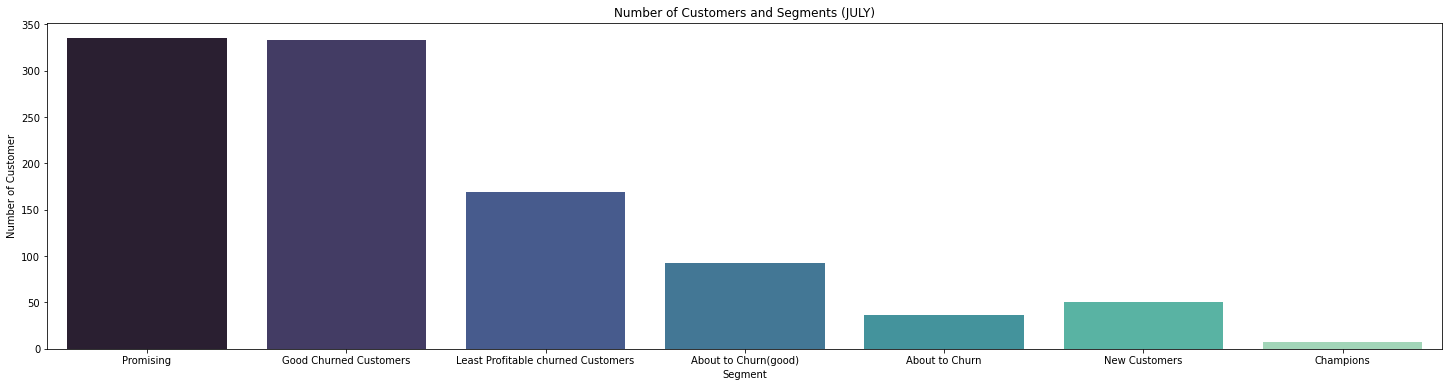

In [112]:
plt.figure(figsize=(25,6))
sns.countplot(x=july_rfm['Segment'], palette = 'mako')
plt.title('Number of Customers and Segments (JULY)')
plt.xlabel('Segment')
plt.ylabel('Number of Customer')
plt.show()

## July

In [113]:
# merge labels with application data
july_rfm =july_rfm[['clientID','Recency', 'Frequency', 'Monetary', 'RFM_Loyalty_Level', 'Segment']]
#application data
#filter out loans that wasnt disbursed to
appdata = sel[~(sel['DisbMonth'].isna())]
#make sure the data doesn't surpass our specified timeframe
appdata = appdata[appdata['Closeddate']<='2021-07-31']

appdata.drop(['LoanId'], axis=1, inplace=True)


app_july = july_rfm.merge(appdata, on='clientID')
# Drop Duplicate information in the dataset
app_july.drop_duplicates(subset ='clientID', keep = 'first', inplace = True)


Get the number of closed and disbursed accounts for customers we've seen from feb - aug

In [114]:
def custcount(df, Class, start, stop, month):

  # get the number of customers that applied for loans in Aug
  test =df[(df['DisbursementDate']>start) & (df['DisbursementDate']<=stop)]
  test = test[~(test['DisbMonth'].isna())]
  #test =test[test['AccountState']=='CLOSED']
  augtest = july_rfm.merge(test, on='clientID')
  #loyalty =augtest.groupby(Class).clientID.count().reset_index()
  loyalty = augtest.groupby(Class).agg({'clientID': 'count'}).reset_index()
  loyalty.rename(columns={'clientID': f"{month}Disb"}, inplace=True)


  # get the number of customers that closed their loans in Aug, only for existing customers
  test =df[(df['Closeddate']>start) & (df['Closeddate']<=stop)]
  test = test[~(test['DisbMonth'].isna())]
  #test =test[test['AccountState']=='CLOSED']
  augtest1 = july_rfm.merge(test, on='clientID')
  #loyalty =augtest.groupby(Class).clientID.count().reset_index()
  loyalty1 = augtest1.groupby(Class).agg({'clientID': 'count'}).reset_index()
  loyalty1.rename(columns={'clientID': f"{month}Closed"}, inplace=True)
  final = loyalty1.merge(loyalty, on=Class)

  return final

final =custcount(sel, 'RFM_Loyalty_Level', '2021-07-31', '2021-08-31', 'Aug')


In [117]:
# Create some simple functions we'll be using to create our summary dataframe

def groupby_mean(x):
    return round(x.mean(),2)

def groupby_count(x):
    return x.nunique()

def groupby_sum(x):
    return x.sum()

def percentage(x):
    return round(((x.sum()/ 68899347.30)*100),1)

def avg_frequency(x):
    '''returns the average days between sales'''
    return (x.max() - x.min()).days/x.count()


    

groupby_mean.__name__ = 'avg'
groupby_count.__name__ = 'count'
groupby_sum.__name__ = 'sum'
avg_frequency.__name__ = 'purchase_frequency'


summary_df = app_july.groupby('RFM_Loyalty_Level').agg({
    'clientID': [ groupby_count],
    'Recency': [ groupby_mean],
    'Frequency': [groupby_mean],
    'Monetary' : [percentage, groupby_mean],
    'Age' : [groupby_mean],
    
    'LoanAmount' : groupby_mean,
    'TimeEmploymentMM' : groupby_mean,
    'TotalTimeAtAddress' : groupby_mean,
    'Income' :[groupby_mean]
   
})

summary_df=summary_df.reset_index()
#merge with aug customer count 
summary =summary_df.merge(final, on='RFM_Loyalty_Level')
#get pr of customers returning for a loan in aug
summary['Pr(Returned)'] = round((summary['AugDisb']/ summary[('clientID', 'count')]), 3)

julysummarylevel =summary
julysummarylevel

RFM_Loyalty_Level (RFM_Loyalty_Level, )  (clientID, count)  (Recency, avg)  \
0          Platinum              Platinum                277            0.31   
1              Gold                  Gold                365           11.27   
2            Silver                Silver                156           19.47   
3            Bronze                Bronze                226           34.22   

   (Frequency, avg)  (Monetary, percentage)  (Monetary, avg)  (Age, avg)  \
0              1.05                    54.7        135968.04       38.23   
1              1.00                    36.1         68097.60       37.49   
2              1.00                     5.9         26066.31       35.81   
3              1.00                     3.4         10239.96       35.06   

   (LoanAmount, avg)  (TimeEmploymentMM, avg)  (TotalTimeAtAddress, avg)  \
0          506010.68                    91.45                     181.20   
1          262436.88                    92.40                     194.84   
2           90629.11                    74.99                     199.15   
3           54231.05                    80.85                     185.30   

   (Income, avg)  AugClosed  AugDisb  Pr(Returned)  
0     6080936.79          6       76         0.274  
1     2496399.32          6       52         0.142  
2    11672898.73          1        2         0.013  
3     1122170.13          0        2         0.009

In [118]:

#get count of aug customers
final = custcount(sel, 'Segment', '2021-07-31', '2021-08-31', 'Aug')

summary_df = app_july.groupby('Segment').agg({
    'clientID': [ groupby_count],
    'Recency': [ groupby_mean],
    'Frequency': [groupby_mean],
    'Monetary' : [percentage, groupby_mean],
    'Age' : [groupby_mean],
    'LoanAmount' : groupby_mean,
    'TimeEmploymentMM' : groupby_mean,
    'TotalTimeAtAddress' : groupby_mean,
    'Income' :[groupby_mean]
   
})

summary_df=summary_df.reset_index()
#merge with aug

summary = summary_df.merge( final, on='Segment', how='left')

#pr of customers that returned for a loan in Aug
summary['Pr(Returned)'] = round((summary['AugDisb']/ summary[('clientID', 'count')]), 3)

julysummarysegment = summary
julysummarysegment

Segment                         (Segment, )  \
0                      About to Churn                      About to Churn   
1                About to Churn(good)                About to Churn(good)   
2                           Champions                           Champions   
3              Good Churned Customers              Good Churned Customers   
4  Least Profitable churned Customers  Least Profitable churned Customers   
5                       New Customers                       New Customers   
6                           Promising                           Promising   

   (clientID, count)  (Recency, avg)  (Frequency, avg)  \
0                 36            2.44              1.03   
1                 93            2.34              1.04   
2                  7            0.00              2.00   
3                333           28.33              1.00   
4                169           30.94              1.00   
5                 51            0.00              1.00   
6                335            0.00              1.00   

   (Monetary, percentage)  (Monetary, avg)  (Age, avg)  (LoanAmount, avg)  \
0                     0.4          8449.51       34.25           27230.69   
1                     6.9         50840.88       38.85          163257.46   
2                     3.4        339157.18       38.86         1311342.86   
3                    37.7         77952.94       37.35          307145.90   
4                     1.8          7320.26       35.23           44541.22   
5                     0.6          7842.45       35.63           32649.10   
6                    49.2        101186.41       37.19          374728.27   

   (TimeEmploymentMM, avg)  (TotalTimeAtAddress, avg)  (Income, avg)  \
0                    54.58                     205.75      499351.85   
1                    86.81                     212.73     2095957.95   
2                    88.43                     201.57     6576270.92   
3                    96.08                     187.80     7658634.26   
4                    73.01                     189.99     1037942.79   
5                    77.92                     206.45      750078.49   
6                    89.75                     180.53     4917199.11   

   AugClosed  AugDisb  Pr(Returned)  
0        NaN      NaN           NaN  
1        1.0      3.0         0.032  
2        NaN      NaN           NaN  
3        3.0      6.0         0.018  
4        NaN      NaN           NaN  
5        1.0     11.0         0.216  
6        7.0    112.0         0.334

## August

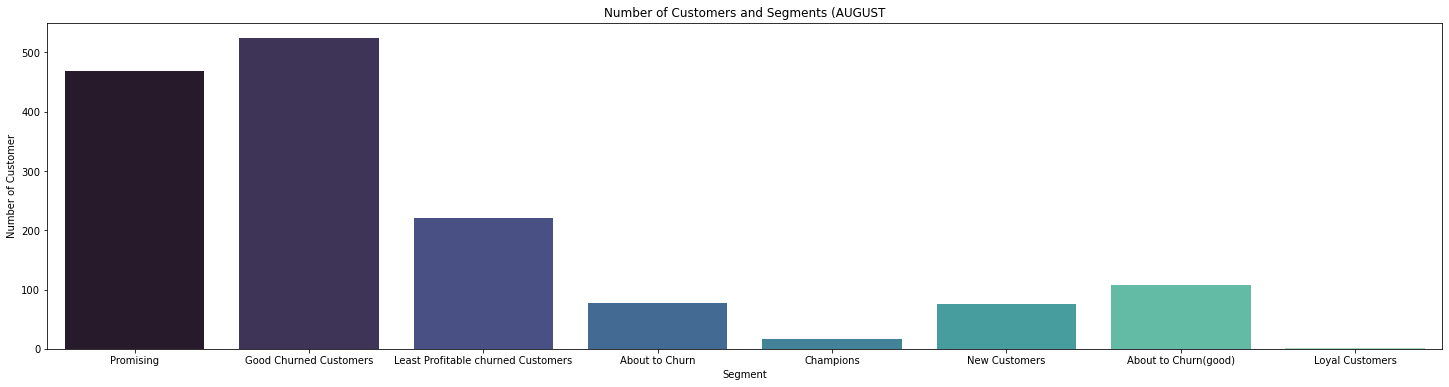

In [139]:
august = RFM(sel, '2021-08-31')

#segments
aug_rfm=Segment(august)
plt.figure(figsize=(25,6))
sns.countplot(x=aug_rfm['Segment'], palette = 'mako')
plt.title('Number of Customers and Segments (AUGUST')
plt.xlabel('Segment')
plt.ylabel('Number of Customer')
plt.show()

In [140]:
# merge labels with application data
aug_rfm =aug_rfm[['clientID','Recency', 'Frequency', 'Monetary', 'RFM_Loyalty_Level', 'Segment']]
#application data
#filter out loans that wasnt disbursed to
appdata = sel[~(sel['DisbMonth'].isna())]
#make sure the data doesn't surpass our specified timeframe
appdata = appdata[appdata['Closeddate']<='2021-08-31']


app_aug = aug_rfm.merge(appdata, on='clientID')
# Drop Duplicate information in the dataset
app_aug.drop_duplicates(subset ='clientID', keep = 'first', inplace = True)


In [141]:
app_aug.shape

(1489, 43)

In [142]:
aug_rfm.shape

(1489, 6)

In [143]:
aug_rfm.Monetary.sum()

99432932.13

In [144]:

#get sept customercount
final =custcount(sel, 'RFM_Loyalty_Level', '2021-08-31', '2021-09-30', 'Sept')

# Create some simple functions we'll be using to create our summary dataframe

def groupby_mean(x):
    return round(x.mean(),2)

def groupby_count(x):
    return x.nunique()

def groupby_sum(x):
    return x.sum()

def percentage(x):
    return round(((x.sum()/ 99432932.13)*100),1)

def avg_frequency(x):
    '''returns the average days between sales'''
    return (x.max() - x.min()).days/x.count()


    

groupby_mean.__name__ = 'avg'
groupby_count.__name__ = 'count'
groupby_sum.__name__ = 'sum'
avg_frequency.__name__ = 'purchase_frequency'


summary_df = app_aug.groupby('RFM_Loyalty_Level').agg({
    'clientID': [ groupby_count],
    'Recency': [ groupby_mean],
    'Frequency': [groupby_mean],
    'Monetary' : [percentage, groupby_mean],
    'Age' : [groupby_mean],
    'LoanAmount' : groupby_mean,
    'TimeEmploymentMM' : groupby_mean,
    'TotalTimeAtAddress' : groupby_mean,
    'Income' :[groupby_mean]
   
})

summary_df=summary_df.reset_index()
#smerge with sept data
summary =summary_df.merge(final, on='RFM_Loyalty_Level')
summary['Pr(Returned)'] = round((summary['SeptDisb']/ summary[('clientID', 'count')]), 3)
augsummarylevel = summary
augsummarylevel

RFM_Loyalty_Level (RFM_Loyalty_Level, )  (clientID, count)  (Recency, avg)  \
0          Platinum              Platinum                390            0.58   
1              Gold                  Gold                516           16.46   
2            Silver                Silver                271           27.14   
3            Bronze                Bronze                312           46.91   

   (Frequency, avg)  (Monetary, percentage)  (Monetary, avg)  (Age, avg)  \
0              1.07                    54.8        139833.38       37.99   
1              1.00                    34.7         66771.26       37.02   
2              1.00                     7.0         25626.84       36.74   
3              1.00                     3.5         11214.98       35.45   

   (LoanAmount, avg)  (TimeEmploymentMM, avg)  (TotalTimeAtAddress, avg)  \
0          496919.58                    94.64                     205.49   
1          254605.74                    86.90                     187.20   
2           84796.69                    84.67                     205.67   
3           49979.70                    77.83                     173.54   

   (Income, avg)  SeptClosed  SeptDisb  Pr(Returned)  
0     6024613.20          13        31         0.079  
1     3940415.74          12        14         0.027  
2     7750242.66           3         0         0.000  
3     1216082.82           5         0         0.000

In [145]:

#get sept customercount
final =custcount(sel, 'Segment', '2021-08-31', '2021-09-30', 'Sept')

summary_df = app_aug.groupby('Segment').agg({
    'clientID': [ groupby_count],
    'Recency': [ groupby_mean],
    'Frequency': [groupby_mean],
    'Monetary' : [percentage, groupby_mean],
    'Age' : [groupby_mean],
    'LoanAmount' : groupby_mean,
    'TimeEmploymentMM' : groupby_mean,
    'TotalTimeAtAddress' : groupby_mean,
    'Income' :[groupby_mean]
   
})

summary_df=summary_df.reset_index()
#summary_df['Pr of returning'] = loyalty['clientID'].values /summary_df['clientID'].values
summary = summary_df.merge( final, on='Segment', how='left')


#pr of customers that returned for a loan in Sept
summary['Pr(Returned)'] = round((summary['SeptDisb']/ summary[('clientID', 'count')]), 3)

augsummarysegment = summary

augsummarysegment

Segment                         (Segment, )  \
0                      About to Churn                      About to Churn   
1                About to Churn(good)                About to Churn(good)   
2                           Champions                           Champions   
3              Good Churned Customers              Good Churned Customers   
4  Least Profitable churned Customers  Least Profitable churned Customers   
5                     Loyal Customers                     Loyal Customers   
6                       New Customers                       New Customers   
7                           Promising                           Promising   

   (clientID, count)  (Recency, avg)  (Frequency, avg)  \
0                 77            5.04              1.01   
1                107            5.01              1.01   
2                 16            0.00              2.06   
3                524           38.97              1.01   
4                220           42.59              1.00   
5                  1            0.00              2.00   
6                 76            0.00              1.00   
7                468            0.00              1.00   

   (Monetary, percentage)  (Monetary, avg)  (Age, avg)  (LoanAmount, avg)  \
0                     0.6          8003.70       36.29           26526.53   
1                     6.1         56955.15       36.46          188552.45   
2                     4.3        266248.90       37.44          859595.31   
3                    38.1         72256.99       37.52          276851.96   
4                     1.7          7769.01       35.39           39761.92   
5                     0.0         25224.35       34.00           27772.00   
6                     0.6          8330.75       36.61           30235.92   
7                    48.5        103060.38       37.14          366738.96   

   (TimeEmploymentMM, avg)  (TotalTimeAtAddress, avg)  (Income, avg)  \
0                    80.21                     216.08      598246.75   
1                    77.84                     185.82     2964615.04   
2                    89.88                     201.62     5250501.45   
3                    92.26                     187.15     7632965.17   
4                    70.52                     182.25      880005.23   
5                    37.00                     126.00      200000.00   
6                    84.75                     210.46      536912.88   
7                    91.24                     197.81     4660299.49   

   SeptClosed  SeptDisb  Pr(Returned)  
0         NaN       NaN           NaN  
1         NaN       NaN           NaN  
2         2.0       5.0         0.312  
3         NaN       NaN           NaN  
4         NaN       NaN           NaN  
5         NaN       NaN           NaN  
6         3.0       8.0         0.105  
7        14.0      32.0         0.068

## September

we did for jan to sept first

In [147]:
sept = rfm.copy()
sept

clientID  Recency  Frequency   Monetary  R  F  M RFMGroup  RFMScore  \
0     22141758194        0          1   62939.72  1  4  1      141         6   
1     22141881355        0          1   62916.94  1  4  2      142         7   
2     22141957171        2          1   17287.33  2  4  3      243         9   
3     22141975874        0          1  222936.72  1  4  1      141         6   
4     22142101256        0          1   82214.95  1  4  1      141         6   
...           ...      ...        ...        ... .. .. ..      ...       ...   
1790  22276932919        0          2  821324.50  1  1  1      111         3   
1791  22279271464        0          2  389188.98  1  1  1      111         3   
1792  22285692921        0          2  532423.78  1  1  1      111         3   
1793  22306021141        0          3  394872.64  1  1  1      111         3   
1794  22331620340       16          3  786909.58  2  1  1      211         4   

     RFM_Loyalty_Level               Segment  
0             Platinum             Promising  
1             Platinum             Promising  
2                 Gold  About to Churn(good)  
3             Platinum             Promising  
4             Platinum             Promising  
...                ...                   ...  
1790          Platinum             Champions  
1791          Platinum             Champions  
1792          Platinum             Champions  
1793          Platinum             Champions  
1794          Platinum  About to Churn(good)  

[1795 rows x 11 columns]

In [148]:
# merge labels with application data
sep_rfm =sept[['clientID','Recency', 'Frequency', 'Monetary', 'RFM_Loyalty_Level', 'Segment']]
#application data
#filter out loans that wasnt disbursed to
appdata = sel[~(sel['DisbMonth'].isna())]
#make sure the data doesn't surpass our specified timeframe
appdata = appdata[appdata['Closeddate']<='2021-09-30']

appdata.drop(['LoanId'], axis=1, inplace=True)


app = sep_rfm.merge(appdata, on='clientID')
# Drop Duplicate information in the dataset
app.drop_duplicates(subset ='clientID', keep = 'first', inplace = True)


In [149]:
sept.Monetary.sum()

110902143.36

In [150]:

# Create some simple functions we'll be using to create our summary dataframe

def groupby_mean(x):
    return round(x.mean(),2)

def groupby_count(x):
    return x.nunique()

def groupby_sum(x):
    return x.sum()

def percentage(x):
    return round(((x.sum()/ 110902143.35)*100),1)

def avg_frequency(x):
    '''returns the average days between sales'''
    return (x.max() - x.min()).days/x.count()


    

groupby_mean.__name__ = 'avg'
groupby_count.__name__ = 'count'
groupby_sum.__name__ = 'sum'
avg_frequency.__name__ = 'purchase_frequency'


summary_df = app.groupby('RFM_Loyalty_Level').agg({
    'clientID': [ groupby_count],
    'Recency': [ groupby_mean],
    'Frequency': [groupby_mean],
    'Monetary' : [percentage, groupby_mean],
    'Age' : [groupby_mean],
    'LoanAmount' : groupby_mean,
    'LoanAmount' : groupby_mean,
    'TimeEmploymentMM' : groupby_mean,
    'TotalTimeAtAddress' : groupby_mean,
    'Income' :[groupby_mean]
   
})

sepsummarylevel=summary_df.reset_index()
sepsummarylevel


RFM_Loyalty_Level clientID Recency Frequency   Monetary               Age  \
                       count     avg       avg percentage        avg    avg   
0          Platinum      488    1.69      1.14       57.2  129927.58  37.74   
1              Gold      589   23.75      1.00       32.7   61519.20  36.70   
2            Silver      298   43.78      1.00        6.4   23910.91  36.39   
3            Bronze      420   65.41      1.00        3.7    9850.54  35.70   

  LoanAmount TimeEmploymentMM TotalTimeAtAddress       Income  
         avg              avg                avg          avg  
0  508833.26            93.40             207.82  10416829.71  
1  261081.61            88.16             186.76   6338366.82  
2   95346.77            82.63             178.15   1684946.43  
3   49146.86            75.15             187.11    951368.92

In [151]:


summary_df = app.groupby('Segment').agg({
    'clientID': [ groupby_count],
    'Recency': [ groupby_mean],
    'Frequency': [groupby_mean],
    'Monetary' : [percentage, groupby_mean],
    'Age' : [groupby_mean],
    'NoChildren' : groupby_mean,
    'LoanAmount' : groupby_mean,
    'TimeEmploymentMM' : groupby_mean,
    'TotalTimeAtAddress' : groupby_mean,
    'Income' :[groupby_mean]
   
})

sepsummarysegment=summary_df.reset_index()
sepsummarysegment

Segment clientID Recency Frequency   Monetary  \
                                         count     avg       avg percentage   
0                      About to Churn       71    9.80      1.03        0.5   
1                About to Churn(good)      210    8.67      1.09       14.8   
2                           Champions       32    0.00      2.09        6.8   
3              Good Churned Customers      596   58.54      1.01       34.6   
4  Least Profitable churned Customers      299   59.94      1.00        1.8   
5                     Loyal Customers        2    0.00      2.00        0.0   
6                       New Customers       79    0.00      1.00        0.5   
7                           Promising      506    0.00      1.00       41.0   

                Age NoChildren LoanAmount TimeEmploymentMM TotalTimeAtAddress  \
         avg    avg        avg        avg              avg                avg   
0    7338.59  34.42       1.10   28385.03            72.28             148.51   
1   78349.04  36.31       1.42  318793.37            90.09             193.26   
2  234408.36  36.75       1.28  716713.16            85.03             229.50   
3   64413.88  37.43       1.58  268028.09            89.83             185.28   
4    6634.36  35.80       1.30   40739.84            71.68             189.08   
5   17601.17  35.50       2.50   33786.00            58.00             259.00   
6    7002.65  36.71       1.68   44213.32            82.72             217.85   
7   89849.76  36.85       1.56  363161.21            89.53             197.49   

        Income  
           avg  
0   1208816.90  
1  23957634.59  
2   4829921.60  
3   2883400.39  
4    809624.64  
5    175000.00  
6    543094.91  
7   4828210.05

## Loyalty Levels; Month-on-Month

In [152]:
julysummarylevel

RFM_Loyalty_Level (RFM_Loyalty_Level, )  (clientID, count)  (Recency, avg)  \
0          Platinum              Platinum                277            0.31   
1              Gold                  Gold                365           11.27   
2            Silver                Silver                156           19.47   
3            Bronze                Bronze                226           34.22   

   (Frequency, avg)  (Monetary, percentage)  (Monetary, avg)  (Age, avg)  \
0              1.05                    54.7        135968.04       38.23   
1              1.00                    36.1         68097.60       37.49   
2              1.00                     5.9         26066.31       35.81   
3              1.00                     3.4         10239.96       35.06   

   (LoanAmount, avg)  (TimeEmploymentMM, avg)  (TotalTimeAtAddress, avg)  \
0          506010.68                    91.45                     181.20   
1          262436.88                    92.40                     194.84   
2           90629.11                    74.99                     199.15   
3           54231.05                    80.85                     185.30   

   (Income, avg)  AugClosed  AugDisb  Pr(Returned)  
0     6080936.79          6       76         0.274  
1     2496399.32          6       52         0.142  
2    11672898.73          1        2         0.013  
3     1122170.13          0        2         0.009

In [153]:
augsummarylevel

RFM_Loyalty_Level (RFM_Loyalty_Level, )  (clientID, count)  (Recency, avg)  \
0          Platinum              Platinum                390            0.58   
1              Gold                  Gold                516           16.46   
2            Silver                Silver                271           27.14   
3            Bronze                Bronze                312           46.91   

   (Frequency, avg)  (Monetary, percentage)  (Monetary, avg)  (Age, avg)  \
0              1.07                    54.8        139833.38       37.99   
1              1.00                    34.7         66771.26       37.02   
2              1.00                     7.0         25626.84       36.74   
3              1.00                     3.5         11214.98       35.45   

   (LoanAmount, avg)  (TimeEmploymentMM, avg)  (TotalTimeAtAddress, avg)  \
0          496919.58                    94.64                     205.49   
1          254605.74                    86.90                     187.20   
2           84796.69                    84.67                     205.67   
3           49979.70                    77.83                     173.54   

   (Income, avg)  SeptClosed  SeptDisb  Pr(Returned)  
0     6024613.20          13        31         0.079  
1     3940415.74          12        14         0.027  
2     7750242.66           3         0         0.000  
3     1216082.82           5         0         0.000

In [154]:
sepsummarylevel

RFM_Loyalty_Level clientID Recency Frequency   Monetary               Age  \
                       count     avg       avg percentage        avg    avg   
0          Platinum      488    1.69      1.14       57.2  129927.58  37.74   
1              Gold      589   23.75      1.00       32.7   61519.20  36.70   
2            Silver      298   43.78      1.00        6.4   23910.91  36.39   
3            Bronze      420   65.41      1.00        3.7    9850.54  35.70   

  LoanAmount TimeEmploymentMM TotalTimeAtAddress       Income  
         avg              avg                avg          avg  
0  508833.26            93.40             207.82  10416829.71  
1  261081.61            88.16             186.76   6338366.82  
2   95346.77            82.63             178.15   1684946.43  
3   49146.86            75.15             187.11    951368.92

In [155]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [157]:
df1=app_july.groupby('Segment').AddresLGA.describe()
df2= app_aug.groupby('Segment').AddresLGA.describe()
df3=app.groupby('Segment').AddresLGA.describe()
display_side_by_side([df1, df2, df3], ['July', 'Aug', 'Sept'])

In [158]:
#EmployerLGA

df1=app_july.groupby('Segment').EmployerLGA.describe()
df2= app_aug.groupby('Segment').EmployerLGA.describe()
df3=app.groupby('Segment').EmployerLGA.describe()
display_side_by_side([df1, df2, df3], ['July', 'Aug', 'Sept'])

In [880]:
display_side_by_side([df1, df2, df3], ['July', 'Aug', 'Sept'])

## K-means Clustering; Month-on-Month

In [400]:
julysummarycluster

Cluster  (Cluster, )  (clientID, count)  (Recency, avg)  (Frequency, avg)  \
0        0            0                 35           53.60              1.77   
1        1            1                756            5.75              1.06   
2        2            2                605           24.94              3.21   
3        3            3               1269           56.42              1.03   

   (Monetary, percentage)  (Monetary, avg)  (Age, avg)  (NoChildren, avg)  \
0                     0.0             1.51       33.37               0.89   
1                    25.4          3886.79       34.20               1.08   
2                    67.6         12936.28       35.02               1.33   
3                    41.4          3777.75       34.02               1.14   

   (LoanAmount, avg)  (TimeEmploymentMM, avg)  (TotalTimeAtAddress, avg)  \
0           12254.29                    65.46                     188.14   
1           14311.77                    68.45                     185.72   
2           15644.46                    71.91                     185.58   
3           14226.36                    68.23                     163.59   

   (Income, avg)  count of Aug customers  Pr(Returned ff mnt)  
0      153258.17                       5                0.143  
1      154309.32                     155                0.205  
2      195932.91                     127                0.210  
3      168925.02                      91                0.072

In [401]:
augsummarycluster

Cluster  (Cluster, )  (clientID, count)  (Recency, avg)  (Frequency, avg)  \
0        0            0                524            7.28              1.05   
1        1            1               1891           61.80              1.00   
2        2            2                608           34.48              2.31   
3        3            3                 42           65.26              1.55   

   (Monetary, percentage)  (Monetary, avg)  (Age, avg)  (NoChildren, avg)  \
0                    14.0          3974.77       33.60               1.16   
1                    48.6          3828.44       34.23               1.15   
2                    37.4          9177.02       34.21               1.18   
3                     0.0             2.19       33.86               0.93   

   (LoanAmount, avg)  (TimeEmploymentMM, avg)  (TotalTimeAtAddress, avg)  \
0           14162.02                    68.26                     186.56   
1           14489.14                    67.98                     174.34   
2           15534.70                    68.09                     176.33   
3           12150.00                    60.48                     173.67   

   (Income, avg)  count of Sept customers  Pr(Returned ff mnt)  
0      163613.68                       51                0.097  
1      164838.85                      168                0.089  
2      189570.50                      139                0.229  
3      141048.48                        4                0.095

In [402]:
sepsummarycluster

Cluster clientID Recency Frequency   Monetary              Age NoChildren  \
             count     avg       avg percentage       avg    avg        avg   
0       0     2027   80.69      1.00       39.9   3829.87  33.96       1.12   
1       1      706    8.25      1.05       14.9   4090.64  34.20       1.24   
2       2      831   40.35      2.40       45.2  10582.29  34.29       1.19   
3       3       43   84.02      1.56        0.0      2.16  34.49       1.09   

  LoanAmount TimeEmploymentMM TotalTimeAtAddress     Income  
         avg              avg                avg        avg  
0   14392.60            67.68             174.93  166265.93  
1   14483.57            69.06             183.46  439015.91  
2   16676.48            67.65             177.01  193682.34  
3   12311.63            64.51             170.51  141256.65

## Segment

In [227]:
julysummarysegment.to_excel('seljulsegment.xlsx')

In [205]:
july_rfm.Segment.value_counts()

New Customers                         298
Promising                             230
Good Churned Customers                190
About to Churn(good)                  186
Least Profitable churned Customers     58
About to Churn                         56
Champions                               5
Loyal Customers                         1
Name: Segment, dtype: int64

In [229]:
augsummarysegment.to_excel('selaugsegment.xlsx')

In [233]:
sepsummarysegment.to_excel('selseptsegment.xlsx')

In [240]:
app.groupby('Segment').AddresLGA.value_counts().to_csv('selsepaddres.csv')

In [235]:
df1= app_july.groupby('Segment')['AddresLGA'].describe()
df2= app_aug.groupby('Segment')['AddresLGA'].describe()
df3= app.groupby('Segment')['AddresLGA'].describe()

In [236]:
#AddresLGA
display_side_by_side([df1, df2, df3], ['July', 'Aug', 'Sept'])

In [889]:
#EmployerLGA
display_side_by_side([df1, df2, df3], ['July', 'Aug', 'Sept'])

In [898]:
#BusinessSector
display_side_by_side([df1, df2, df3], ['July', 'Aug', 'Sept'])

In [906]:
#Age Group
display_side_by_side([df1, df2, df3], ['July', 'Aug', 'Sept'])

In [238]:
#To understand the gender divide of each cluster
data2 = pd.DataFrame(app.groupby(['Segment','Gender'])['Gender'].count())
data2

Gender
Segment                            Gender        
About to Churn                     FEMALE      43
                                   MALE       116
About to Churn(good)               FEMALE      75
                                   MALE       212
Champions                          FEMALE      17
                                   MALE        35
Good Churned Customers             FEMALE      74
                                   MALE       235
Least Profitable churned Customers FEMALE      38
                                   MALE       102
Loyal Customers                    FEMALE       1
                                   MALE         1
New Customers                      FEMALE     101
                                   MALE       243
Promising                          FEMALE     123
                                   MALE       379

# K means Clustering
to determine optimum clusters and observe their characteristics

In [160]:
#remove outliers
rfm_table = rfm_table[rfm_table['Monetary']<rfm_table['Monetary'].quantile(0.99)]


#Handle negative and zero values so as to handle infinite numbers during log transformation
def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num
#Apply handle_neg_n_zero function to Recency and Monetary columns 
rfm_table['Recency'] = [handle_neg_n_zero(x) for x in rfm_table.Recency]
rfm_table['Monetary'] = [handle_neg_n_zero(x) for x in rfm_table.Monetary]

#Perform Log transformation to bring data into normal or near normal distribution
Log_Tfd_Data = rfm_table[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

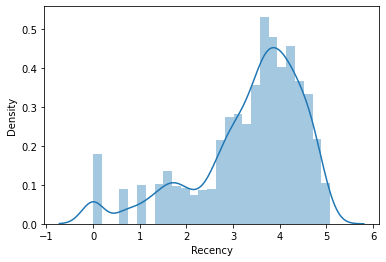

In [161]:
#Data distribution after data normalization for Recency
Recency_Plot = Log_Tfd_Data['Recency']
ax = sns.distplot(Recency_Plot)

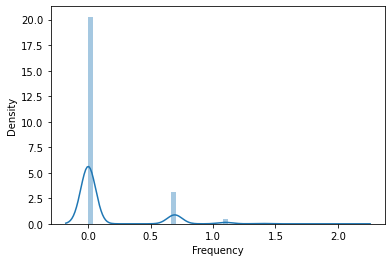

In [162]:
#Data distribution after data normalization for Frequency
Frequency_Plot = Log_Tfd_Data.query('Frequency < 10')['Frequency']
ax = sns.distplot(Frequency_Plot)

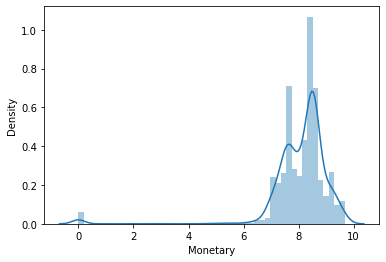

In [163]:
#Data distribution after data normalization for Monetary
Monetary_Plot = Log_Tfd_Data.query('Monetary < 40000')['Monetary']
ax = sns.distplot(Monetary_Plot)

In [164]:
from sklearn.preprocessing import StandardScaler

#Bring the data on same scale
scaleobj = StandardScaler()
Scaled_Data = scaleobj.fit_transform(Log_Tfd_Data)

#Transform it back to dataframe
Scaled_Data = pd.DataFrame(Scaled_Data, index = rfm_table.index, columns = Log_Tfd_Data.columns)

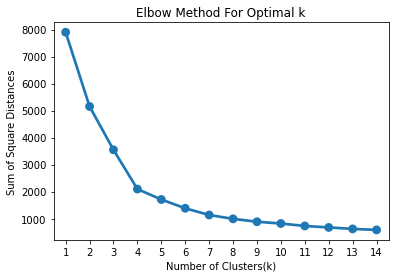

In [165]:
from sklearn.cluster import KMeans

sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(Scaled_Data)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [166]:
#Perform K-Mean Clustering or build the K-Means clustering model
KMean_clust = KMeans(n_clusters= 4, init= 'k-means++', max_iter= 1000)
KMean_clust.fit(Scaled_Data)

#Find the clusters for the observation given in the dataset
rfm_table['Cluster'] = KMean_clust.labels_
rfm_table.head()

clientID  Recency  Frequency  Monetary    T  RecencyCluster  \
0  22141758042       85          1    3374.0  116               0   
1  22142274105      123          1    3466.0  145               0   
2  22142501225       81          1    2762.0  137               0   
3  22143621326      120          1    2095.0  150               0   
4  22144775491      144          1    3399.0  149               0   

   FrequencyCluster  MonetaryCluster RecencyClusterTag FrequencyClusterTag  \
0                 0                0              >=79                   1   
1                 0                0              >=79                   1   
2                 0                0              >=79                   1   
3                 0                0              >=79                   1   
4                 0                0              >=79                   1   

  MonetaryClusterTag  Cluster  
0             <=3659        0  
1             <=3659        0  
2             <=3659        0  
3             <=3659        0  
4             <=3659        0

In [167]:
rfm_table.Cluster.value_counts()

0    1727
1     464
2     410
3      32
Name: Cluster, dtype: int64

<Figure size 504x504 with 0 Axes>

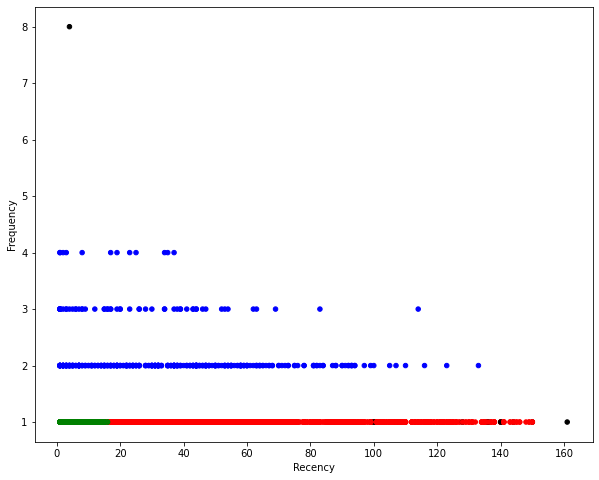

In [168]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))

##Scatter Plot Frequency Vs Recency 
#red=0, green=1, blue=2, black=3
Colors = ["red", "green", "blue", 'black']
rfm_table['Color'] =rfm_table['Cluster'].map(lambda p: Colors[p])
ax =rfm_table.plot(    
    kind="scatter", 
    x="Recency", y="Frequency",
    figsize=(10,8),
    c =rfm_table['Color']
)

In [180]:
rfm_table.head()

clientID  Recency  Frequency  Monetary    T  RecencyCluster  \
0  22141758042       85          1    3374.0  116               0   
1  22142274105      123          1    3466.0  145               0   
2  22142501225       81          1    2762.0  137               0   
3  22143621326      120          1    2095.0  150               0   
4  22144775491      144          1    3399.0  149               0   

   FrequencyCluster  MonetaryCluster RecencyClusterTag FrequencyClusterTag  \
0                 0                0              >=79                   1   
1                 0                0              >=79                   1   
2                 0                0              >=79                   1   
3                 0                0              >=79                   1   
4                 0                0              >=79                   1   

  MonetaryClusterTag  Cluster Color  R  F  M RFMGroup  RFMScore  \
0             <=3659        0   red  4  4  3      443        11   
1             <=3659        0   red  4  4  3      443        11   
2             <=3659        0   red  4  4  3      443        11   
3             <=3659        0   red  4  4  3      443        11   
4             <=3659        0   red  4  4  3      443        11   

  RFM_Loyalty_Level  
0            Bronze  
1            Bronze  
2            Bronze  
3            Bronze  
4            Bronze

<Figure size 504x504 with 0 Axes>

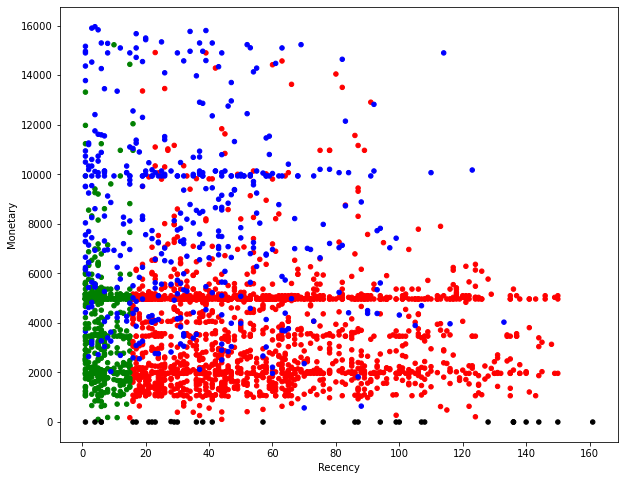

In [169]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))

##Scatter Plot Frequency Vs Recency
Colors = ["red", "green", "blue", 'black']
rfm_table['Color'] =rfm_table['Cluster'].map(lambda p: Colors[p])
ax =rfm_table.plot(    
    kind="scatter", 
    x="Recency", y="Monetary",
    figsize=(10,8),
    c =rfm_table['Color']
)

In [181]:
rfm_table.groupby('RFM_Loyalty_Level')['Monetary'].describe()

count         mean          std  min     25%     50%  \
RFM_Loyalty_Level                                                         
Platinum           735.0  7281.128762  3135.598524  1.0  4966.0  5984.0   
Gold               885.0  4146.825254  2091.938398  1.0  2528.0  4666.0   
Silver             483.0  3095.545300  1534.165230  1.0  1873.0  2776.0   
Bronze             530.0  1985.616472   864.724696  1.0  1483.0  1966.0   

                       75%       max  
RFM_Loyalty_Level                     
Platinum           9932.00  15955.98  
Gold               4966.00  14898.00  
Silver             4966.00   5099.33  
Bronze             2254.75   4162.97

In [182]:
rfm_table.groupby('Cluster')['Monetary'].describe()

count         mean          std    min        25%       50%  \
Cluster                                                                 
0        1727.0  3675.959705  2096.175437  109.0  1966.0000  3466.000   
1         464.0  3941.582629  2161.860551  110.0  2113.0000  3940.655   
2         410.0  8272.605732  3553.960583  571.0  5438.3125  8191.500   
3          32.0     1.562500     3.181981    1.0     1.0000     1.000   

              75%       max  
Cluster                      
0         4966.00  14912.47  
1         5032.67  15225.98  
2        10132.00  15955.98  
3            1.00     19.00

In [318]:
# density plot and ine plot

# Create some simple functions we'll be using to create our summary dataframe

def groupby_mean(x):
    return x.mean()

def groupby_count(x):
    return x.count()

def groupby_sum(x):
    return x.sum()

def percentage(x):
    return round(((x.sum()/ 11569095.100000001)*100),1)

def avg_frequency(x):
    '''returns the average days between sales'''
    return (x.max() - x.min()).days/x.count()

groupby_mean.__name__ = 'avg'
groupby_count.__name__ = 'count'
groupby_sum.__name__ = 'sum'
avg_frequency.__name__ = 'purchase_frequency'

summary_df = rfm_table.groupby('RFM_Loyalty_Level').agg({
    'clientID': [ groupby_count],
    'Recency': [ groupby_mean],
    'Frequency': [groupby_mean],
    'Monetary' : [percentage, groupby_mean]
})

summary_df=summary_df.reset_index()
summary_df

RFM_Loyalty_Level clientID    Recency Frequency   Monetary             
                       count        avg       avg percentage          avg
0          Platinum      735  23.695238  1.662585       46.3  7281.128762
1              Gold      885  34.209040  1.010169       31.7  4146.825254
2            Silver      483  57.863354  1.000000       12.9  3095.545300
3            Bronze      530  82.798113  1.000000        9.1  1985.616472

In [326]:
summary_df = rfm_table.groupby('Cluster').agg({
    'clientID': [ groupby_count],
    'Recency': [ groupby_mean],
    'Frequency': [groupby_mean],
    'Monetary' : [percentage, groupby_mean]
})

summary_df=summary_df.reset_index()
summary_df

Cluster clientID    Recency Frequency   Monetary             
             count        avg       avg percentage          avg
0       0     1727  57.984366  1.000000       54.9  3675.959705
1       1      464   6.579741  1.002155       15.8  3941.582629
2       2      410  34.309756  2.190244       29.3  8272.605732
3       3       32  70.718750  1.218750        0.0     1.562500

In [327]:
summary_df = rfm_table.groupby('Segment').agg({
    'clientID': [ groupby_count],
    'Recency': [ groupby_mean],
    'Frequency': [groupby_mean],
    'Monetary' : [percentage, groupby_mean]
})

summary_df=summary_df.reset_index()
summary_df

Segment clientID    Recency Frequency  \
                                         count        avg       avg   
0                      About to Churn      108  50.472222  2.129630   
1                          Chamipions      255  17.156863  2.262745   
2              Good Churned Customers       49  86.653061  2.061224   
3                         Hibernating      563  51.269982  1.000000   
4  Least Profitable churned Customers      593  96.905565  1.000000   
5                       New Customers     1065  17.953052  1.000000   

    Monetary               
  percentage          avg  
0        7.9  8471.203796  
1       18.3  8303.727020  
2        3.1  7394.794898  
3       18.1  3709.764174  
4       18.0  3510.490152  
5       34.6  3759.710667

In [324]:
# Dropping a level down
summary_df.columns = summary_df.columns.droplevel(0)
summary_df

count        avg       avg  percentage          avg
0  Platinum    735  23.695238  1.662585        46.3  7281.128762
1      Gold    885  34.209040  1.010169        31.7  4146.825254
2    Silver    483  57.863354  1.000000        12.9  3095.545300
3    Bronze    530  82.798113  1.000000         9.1  1985.616472

In [185]:
import squarify

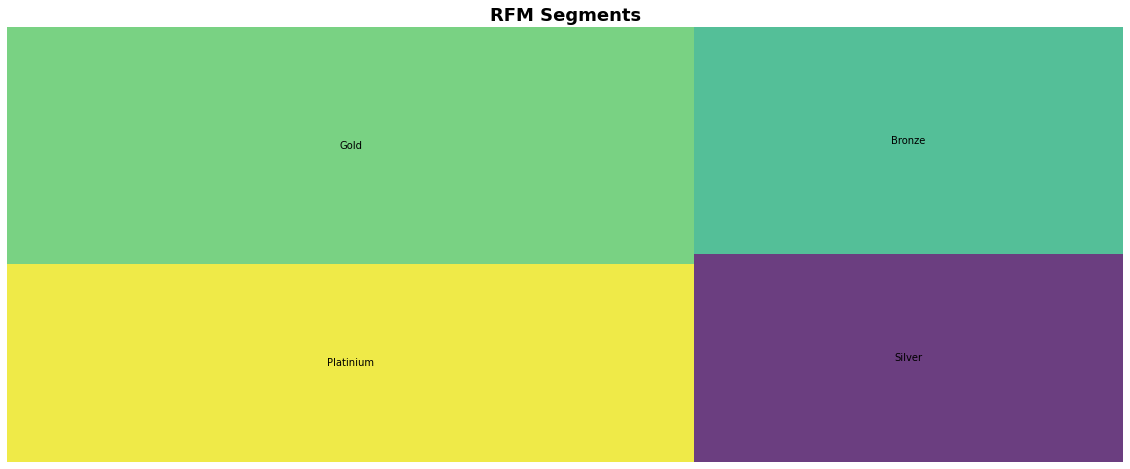

In [186]:
# monetary values of each of the segments
#Create our RFM Segment plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(20, 8)
squarify.plot(sizes=summary_df['count'], 
              label=['Platinium',
                     'Gold',
                     'Silver',
                     'Bronze'], alpha=0.8 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

# RFM clustering function

In [ ]:
def RFM_Clustering(rfm_table):
  ''' function to get optimum clusters based on rfm values
  '''

  #rfm_table = rfm_table[['clientID', 'Recency', 'Frequency', 'Monetary']]
  #Handle negative and zero values so as to handle infinite numbers during log transformation
  def handle_neg_n_zero(num):
      if num <= 0:
          return 1
      else:
          return num
  #Apply handle_neg_n_zero function to Recency and Monetary columns 
  rfm_table['Recency'] = [handle_neg_n_zero(x) for x in rfm_table.Recency]
  rfm_table['Monetary'] = [handle_neg_n_zero(x) for x in rfm_table.Monetary]

  #Perform Log transformation to bring data into normal or near normal distribution
  Log_Tfd_Data = rfm_table[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

  from sklearn.preprocessing import StandardScaler

  #Bring the data on same scale
  scaleobj = StandardScaler()
  Scaled_Data = scaleobj.fit_transform(Log_Tfd_Data)

  #Transform it back to dataframe
  Scaled_Data = pd.DataFrame(Scaled_Data, index = rfm_table.index, columns = Log_Tfd_Data.columns)

  #Perform K-Mean Clustering or build the K-Means clustering model
  KMean_clust = KMeans(n_clusters= 4, init= 'k-means++', max_iter= 1000)
  KMean_clust.fit(Scaled_Data)

  #Find the clusters for the observation given in the dataset
  rfm_table['Cluster'] = KMean_clust.labels_

  return rfm_table

july =RFM_Clustering(july)
#merge with application data


# K-Means Clustering with Application Data

## July

In [648]:
jul = Lite[Lite['Closeddate']<='2021-07-31']
jul= jul[jul['AccountState']=='CLOSED']
jul= jul[~(jul['DisbMonth'].isna())]

#filter neeeded fileds from rfm_table
rfm = july_rfm[['clientID', 'Recency', 'Frequency','Monetary']]

#merge
data = jul.merge(rfm, on='clientID')
data.head()

LoanId AccountState AccountSubstate CreationDate DisbursementDate  \
0  92038233       CLOSED             NaN   2021-05-15       2021-05-15   
1  92043589       CLOSED             NaN   2021-05-25       2021-05-25   
2  92029219       CLOSED             NaN   2021-04-24       2021-04-24   
3  92043620       CLOSED             NaN   2021-05-25       2021-05-26   
4  92043695       CLOSED             NaN   2021-05-25       2021-05-30   

    DisbMonth  Age          DocumentType  DTI EducationStatus   EmployerLGA  \
0  2021-05-01   25  Voters Identity Card  0.0       Secondary  Amuwo-Odofin   
1  2021-05-01   43       Drivers License  0.0        Graduate   Akure South   
2  2021-04-01   43       Drivers License  0.0        Graduate   Akure South   
3  2021-05-01   24                   BVN  0.0        Graduate      Alimosho   
4  2021-05-01   43                   NaN  0.0        Graduate         Agege   

  EmployerState  Gender    Income  LoanAmount MaritalStatus  NoChildren  \
0         Lagos    MALE   40000.0      6800.0        Single           0   
1          Ondo    MALE   40000.0     20000.0       Married           2   
2          Ondo    MALE  120000.0     10400.0       Married           2   
3         Lagos  FEMALE  100000.0     15000.0        Single           0   
4         Lagos    MALE  150000.0     20000.0        Single           0   

   RepaymentBank         AddresLGA ResidentialStatus  TimeEmploymentMM  \
0    Access Bank  Ajeromi-Ifelodun           Renting                29   
1            UBA       Akure South             Owner               111   
2            UBA       Akure South             Owner               109   
3  Fidelity Bank      Oshodi-Isolo    With Relatives                17   
4        GT Bank      Amuwo-Odofin           Renting               162   

   TotalTimeAtAddress    BusinessSector EmploymentPosition GBFlag  MaxDPD  \
0               318.0     Manufacturing                NaN   Good    -2.0   
1               222.0       Agriculture                NaN   Good     0.0   
2               222.0       Agriculture                NaN   Good    -8.0   
3               196.0  Industrial Goods                NaN   Good   -24.0   
4               146.0          Services                NaN   Good    -4.0   

  (DueDate) FPD        FPD  Closeddate MaturityDate  EarlySettlementFlg  \
0    2021-06-14  PAID IN 7  2021-06-12   2021-07-14                   1   
1    2021-06-24  PAID IN 7  2021-06-24   2021-07-24                   1   
2    2021-05-24  PAID IN 7  2021-05-16   2021-06-23                   1   
3    2021-06-25  PAID IN 7  2021-06-01   2021-07-25                   1   
4    2021-06-29  PAID IN 7  2021-06-25   2021-08-28                   1   

    WeekDay  DayOfTheMonth timeindayselect MobileNetwork   Channels  \
0  Saturday             15       6am - 8am           GLO  Renmobile   
1   Tuesday             25     10am - 12pm           MTN  Renmobile   
2  Saturday             24      8am - 10am           MTN  Renmobile   
3   Tuesday             25     10am - 12pm       9mobile  Renmobile   
4   Tuesday             25      12pm - 2pm       9mobile  Renmobile   

      clientID  Recency  Frequency  Monetary  
0  22255490492        6          1   1303.00  
1  22243090415        3          2   7052.00  
2  22243090415        3          2   7052.00  
3  22159134290       13          1   3316.00  
4  22293284211       36          2  13971.98

In [649]:
data.isna().sum()

LoanId                   0
AccountState             0
AccountSubstate       3116
CreationDate             0
DisbursementDate         0
DisbMonth                0
Age                      0
DocumentType           729
DTI                      0
EducationStatus          0
EmployerLGA             59
EmployerState            7
Gender                   0
Income                   0
LoanAmount               0
MaritalStatus            0
NoChildren               0
RepaymentBank            0
AddresLGA               36
ResidentialStatus       62
TimeEmploymentMM         0
TotalTimeAtAddress       0
BusinessSector           0
EmploymentPosition    2880
GBFlag                   0
MaxDPD                   0
(DueDate) FPD            0
FPD                      0
Closeddate               0
MaturityDate             0
EarlySettlementFlg       0
WeekDay                  0
DayOfTheMonth            0
timeindayselect          0
MobileNetwork            0
Channels                 0
clientID                 0
R

In [650]:
#drop fields with too many missing values

miss = [i for i in data.columns if data[i].isna().sum() >= 0.7*len(data[i])]
data = data.drop(miss, axis=1)


#drop duplicate data points

data = data.drop_duplicates(subset='clientID', keep = 'first')
data.shape

(2586, 38)

In [651]:
data.drop(['CreationDate', 'DisbursementDate',
       'DisbMonth','GBFlag','EarlySettlementFlg','Closeddate', 'MaturityDate' ,'(DueDate) FPD', 'FPD', 'DocumentType', 'DTI', 'LoanId','LoanAmount','MaxDPD', 'AccountState', 'RepaymentBank'], axis=1, inplace=True)

#fill missing values
data['AddresLGA'].fillna(data['AddresLGA'].mode()[0], inplace=True)
data['EmployerLGA'].fillna(data['EmployerLGA'].mode()[0], inplace=True)
data['EmployerState'].fillna(data['EmployerState'].mode()[0], inplace=True)
data['ResidentialStatus'].fillna(data['ResidentialStatus'].mode()[0], inplace=True)

In [652]:
#set clientID as index
data.set_index('clientID', inplace=True)

## treating categorical variables

In [653]:
#mapping the unique categorical values to 0 and 1
gender= {'MALE':0, 'FEMALE':1}
data['Gender']= data['Gender'].map(gender)

In [654]:
# LGA in each state
FCT = [
    'Gwagwalada',
    'Kuje',
    'Abaji',
    'Abuja Municipal',
    'Bwari',
    'Kwali'
]

Rivers=['Eleme', 'Port Harcourt']

lagos_mainland = [
    'Alimosho',
    'Ikorodu',
    'Agege',
    'Kosofe',
    'Ifako-Ijaye',
    'Lagos Mainland',
    'Ikeja',
    'Oshodi-Isolo',
    'Surulere',
    'Shomolu',
    'Amuwo-Odofin',
    'Ojo',
    'Mushin',
    'Apapa',
    'Badagry',
    'Ajeromi-Ifelodun',
    'Egbeda',
]

lagos_island = [
    'Eti-Osa',
    'Ibeju/Lekki',
    'Eti Osa',
    'Lagos Island',
    'Epe',
]

# Regroup Address LGA
data['Address_LGA'] = np.where(
    data['AddresLGA'].isin(FCT), 'FCT', np.where(
    data['AddresLGA'].isin(lagos_mainland), 'Lagos Mainland', np.where(
    data['AddresLGA'].isin(lagos_island), 'Lagos Island', np.where(
    data['AddresLGA'].isin(Rivers), 'Rivers','Others'))))

data['Address_LGA'].value_counts()

Lagos Mainland    1090
Others             712
FCT                419
Lagos Island       194
Rivers             171
Name: Address_LGA, dtype: int64

In [655]:
# Regroup Employer's LGA
data['Employer_LGA'] = np.where(
    data['EmployerLGA'].isin(FCT), 'FCT', np.where(
    data['EmployerLGA'].isin(lagos_mainland), 'Lagos Mainland', np.where(
    data['EmployerLGA'].isin(lagos_island), 'Lagos Island',np.where(
    data['EmployerLGA'].isin(Rivers), 'Rivers','Others'))))

data['Employer_LGA'].value_counts()

Lagos Mainland    991
Others            626
FCT               546
Lagos Island      280
Rivers            143
Name: Employer_LGA, dtype: int64

## Bivariate analysis of numerica variables

Text(0.5, 1.0, 'Scatter plot between Age and Income')

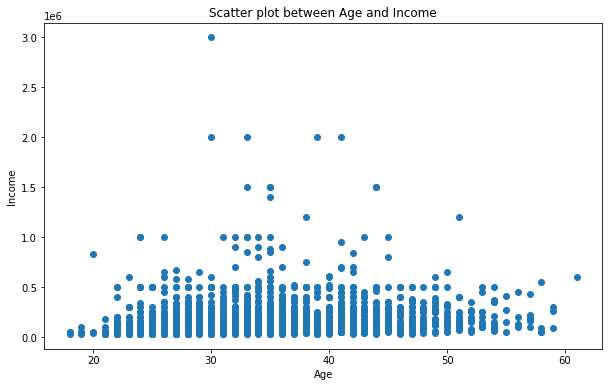

In [635]:
plt.figure(figsize=(10,6))
plt.scatter(data['Age'],data['Income'], marker='o');
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Scatter plot between Age and Income')


Text(0.5, 1.0, 'Scatter plot between Age and T')

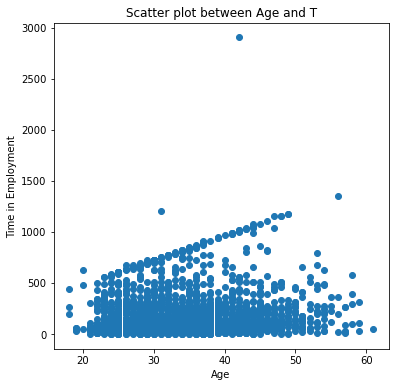

In [527]:
plt.figure(figsize=(6,6))
plt.scatter(data['Age'],data['TotalTimeAtAddress'], marker='o');
plt.xlabel('Age')
plt.ylabel('Time in Employment')
plt.title('Scatter plot between Age and T')

Text(0.5, 1.0, 'Scatter plot between Age and T')

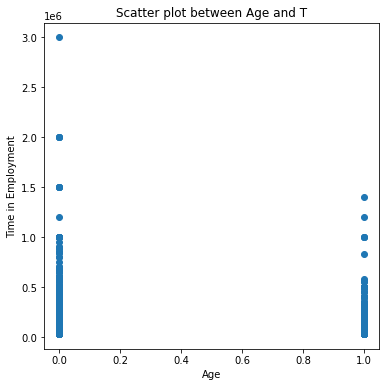

In [529]:
plt.figure(figsize=(6,6))
plt.scatter(data['Gender'],data['Income'], marker='o');
plt.xlabel('Age')
plt.ylabel('Time in Employment')
plt.title('Scatter plot between Age and T')

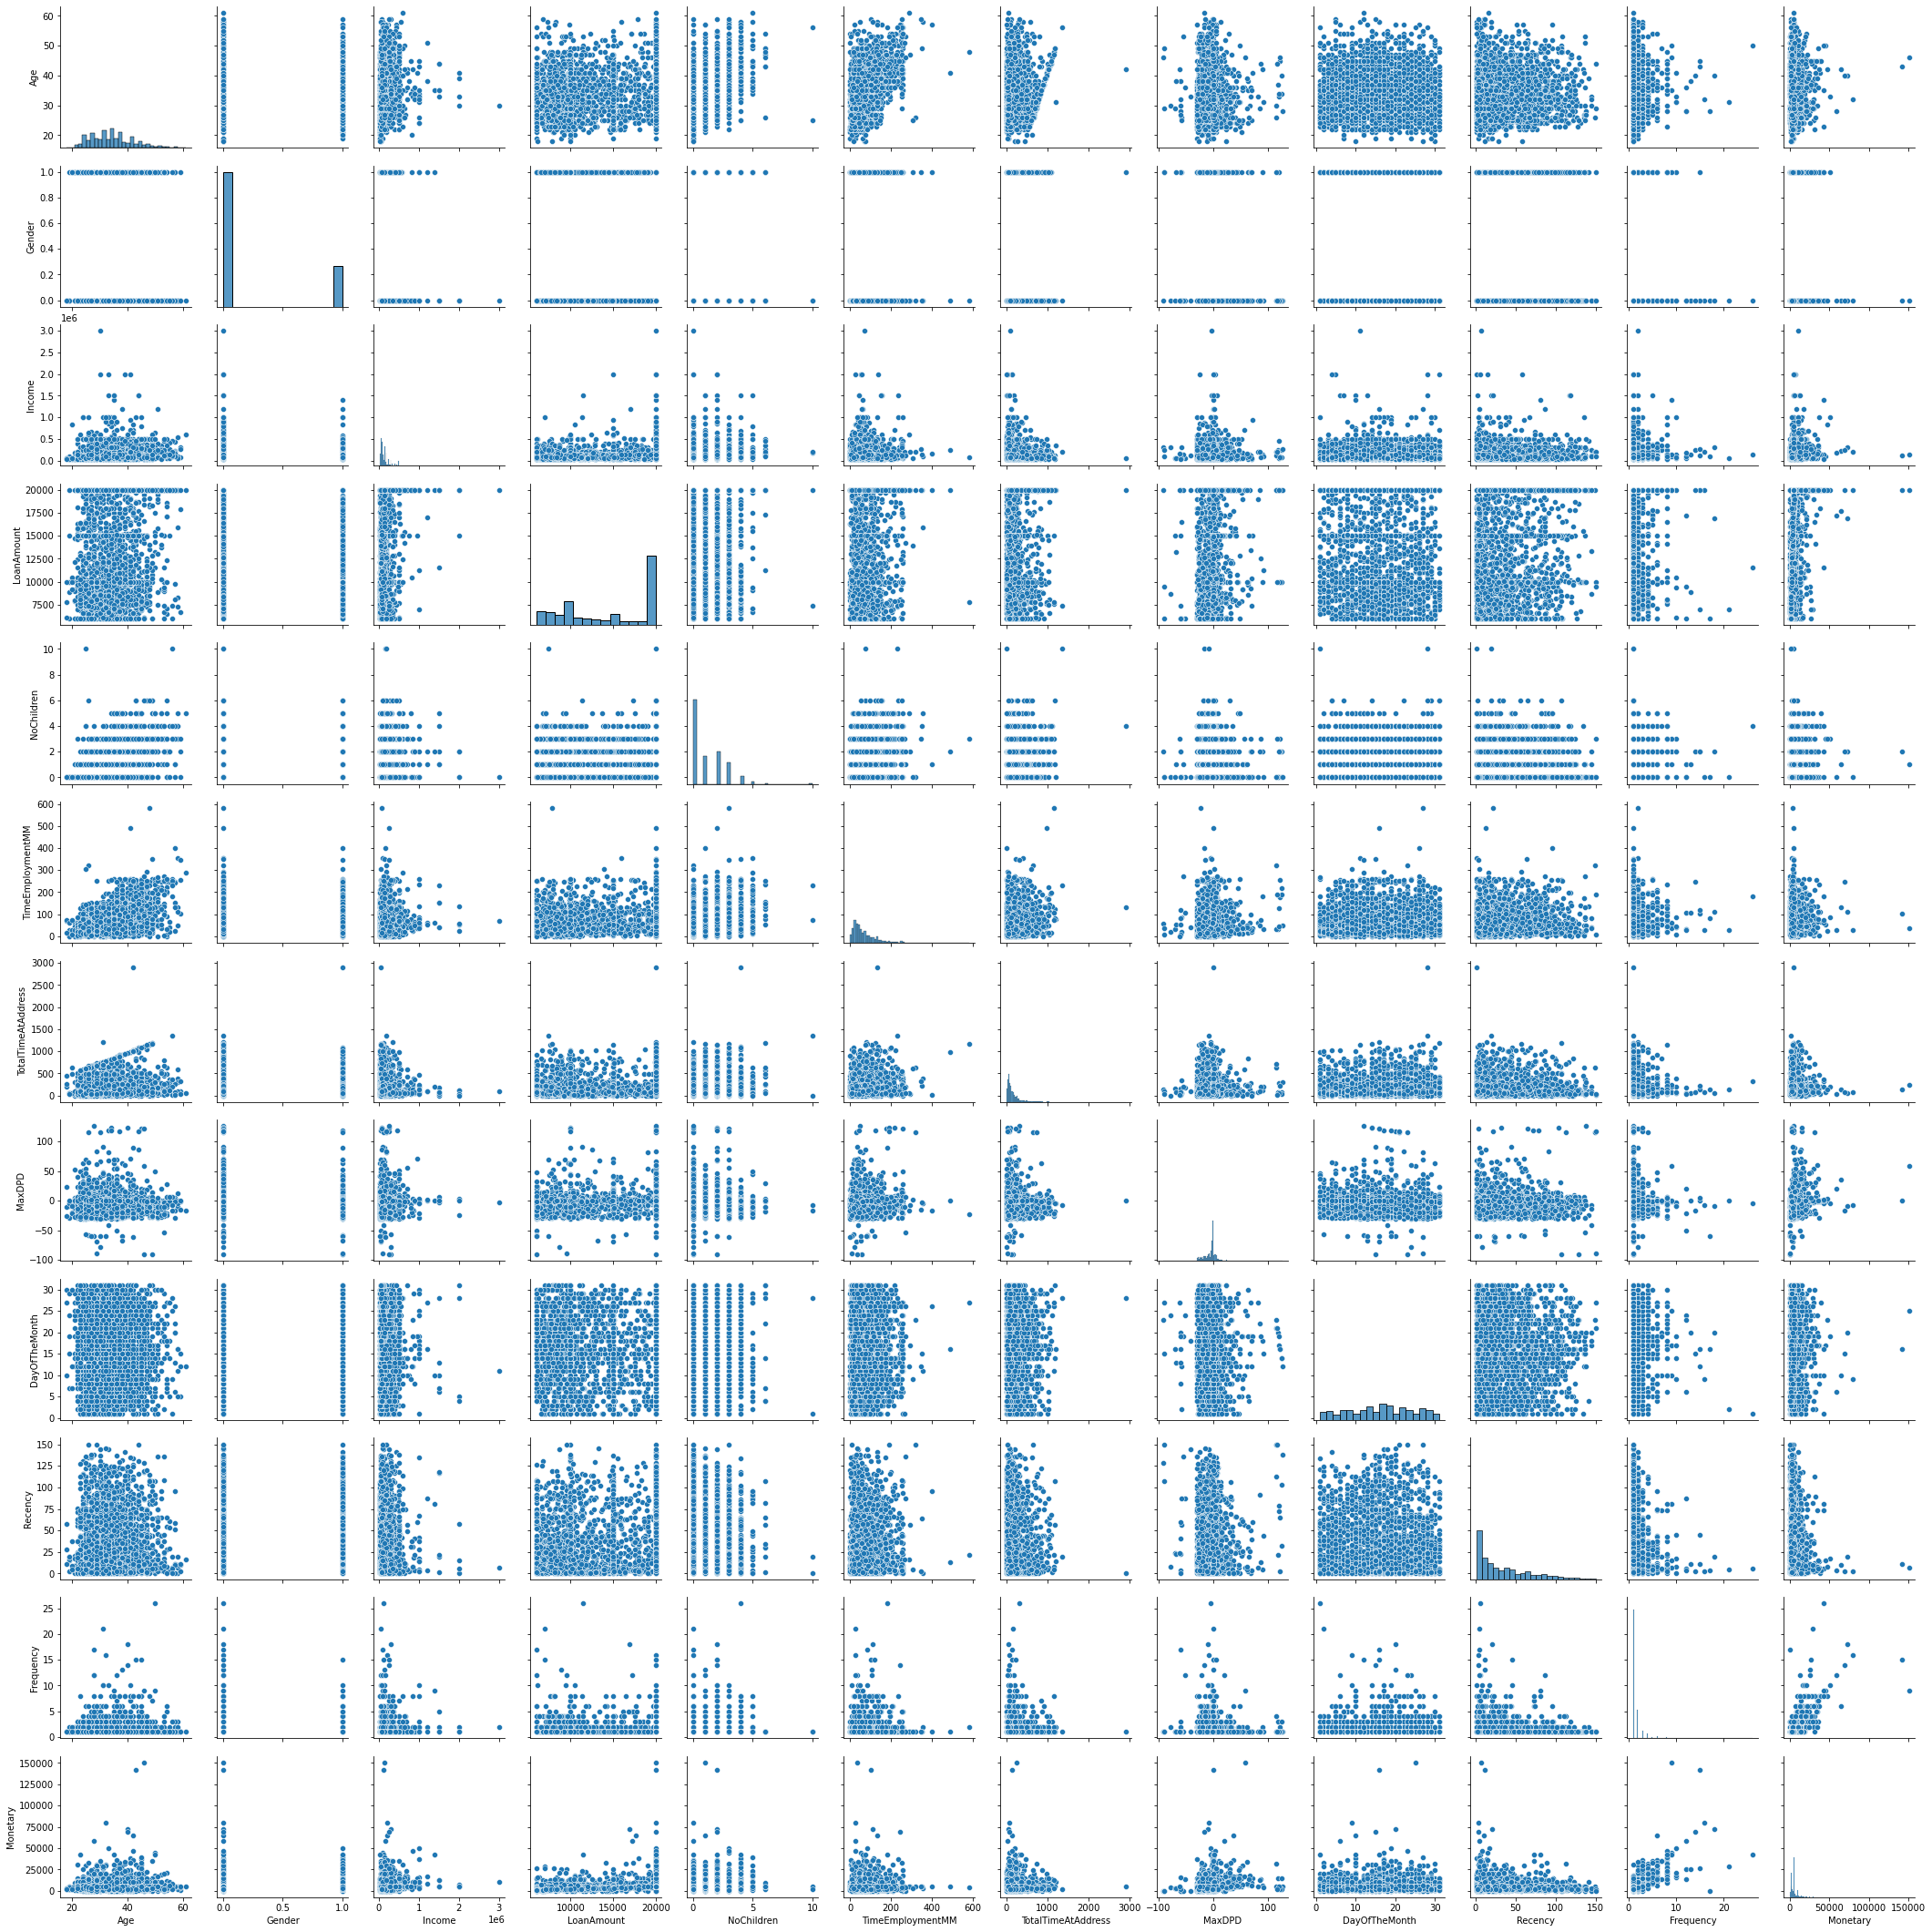

In [495]:


sns.pairplot(data)

In [636]:
data.drop(['AddresLGA', 'EmployerLGA', 'EmployerState'], axis=1, inplace=True)

<AxesSubplot:>

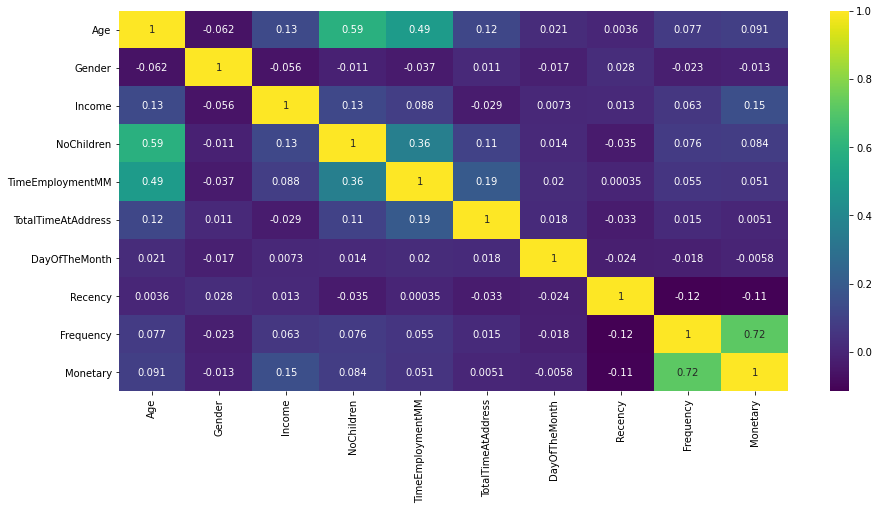

In [530]:
fig_dims = (15, 7)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(data.corr(), annot=True, cmap='viridis')

## standardzing the feature

In [656]:
num= data.select_dtypes(['float64', 'int64'])
#standard scaling the features to bring them around the same scale
scaler = StandardScaler()
data1[num.columns] = scaler.fit_transform(data[num.columns])
data1 = pd.get_dummies(data)
data1.shape

(2586, 379)

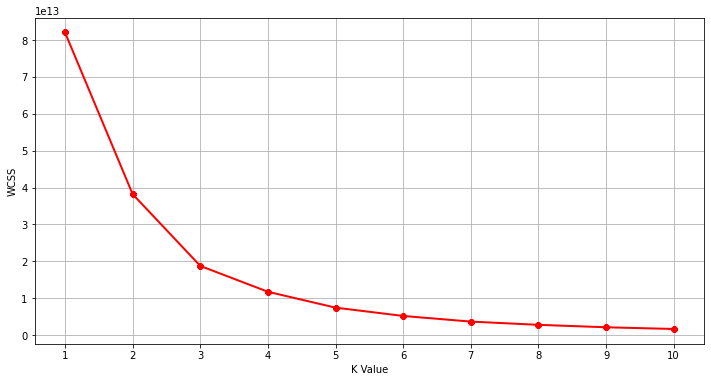

In [657]:
x= data1.copy

# Create an object (which we would call kmeans)
# The number in the brackets is K, or the number of clusters we are aiming for
kmeans = KMeans(3)

wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(data1)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

In [540]:
#Finding out the silhouette score to see if we have built a good model
#print(silhouette_score(clusters, kmeans.labels_, metric='euclidean'))

In [669]:
#assign the optimal number of clusters as 5
kmeans_new = KMeans(3)
# Fit the data
kmeans_new.fit(data1)
# Create a new data frame with the predicted clusters
clusters_new = data1.copy()
clusters_new['cluster_pred'] = kmeans_new.fit_predict(data1)

#mapping the gender variable back to 'male' and 'female'
gender= {0:'Male',1:'Female'}
clusters_new['Gender']= clusters_new['Gender'].map(gender)

In [670]:
# merge with main data 
new =pd.merge(data, clusters_new[['cluster_pred']], left_index=True, right_index=True)

In [671]:
new.head()

Age EducationStatus      EmployerLGA EmployerState  Gender  \
clientID                                                                  
22255490492   25       Secondary     Amuwo-Odofin         Lagos       0   
22243090415   43        Graduate      Akure South          Ondo       0   
22159134290   24        Graduate         Alimosho         Lagos       1   
22293284211   43        Graduate            Agege         Lagos       0   
22245652590   45        Graduate  Abuja Municipal           FCT       0   

               Income MaritalStatus  NoChildren         AddresLGA  \
clientID                                                            
22255490492   40000.0        Single           0  Ajeromi-Ifelodun   
22243090415   40000.0       Married           2       Akure South   
22159134290  100000.0        Single           0      Oshodi-Isolo   
22293284211  150000.0        Single           0      Amuwo-Odofin   
22245652590  126000.0       Married           1        Gwagwalada   

            ResidentialStatus  TimeEmploymentMM  TotalTimeAtAddress  \
clientID                                                              
22255490492           Renting                29               318.0   
22243090415             Owner               111               222.0   
22159134290    With Relatives                17               196.0   
22293284211           Renting               162               146.0   
22245652590           Renting                25                49.0   

               BusinessSector   WeekDay  DayOfTheMonth timeindayselect  \
clientID                                                                 
22255490492     Manufacturing  Saturday             15       6am - 8am   
22243090415       Agriculture   Tuesday             25     10am - 12pm   
22159134290  Industrial Goods   Tuesday             25     10am - 12pm   
22293284211          Services   Tuesday             25      12pm - 2pm   
22245652590        Government   Tuesday             22      12pm - 2pm   

            MobileNetwork   Channels  Recency  Frequency  Monetary  \
clientID                                                             
22255490492           GLO  Renmobile        6          1   1303.00   
22243090415           MTN  Renmobile        3          2   7052.00   
22159134290       9mobile  Renmobile       13          1   3316.00   
22293284211       9mobile  Renmobile       36          2  13971.98   
22245652590           MTN    Web App        2          1   1966.00   

                Address_LGA    Employer_LGA  cluster_pred  
clientID                                                   
22255490492  Lagos Mainland  Lagos Mainland             0  
22243090415          Others          Others             0  
22159134290  Lagos Mainland  Lagos Mainland             0  
22293284211  Lagos Mainland  Lagos Mainland             0  
22245652590             FCT             FCT             0

In [672]:
new.cluster_pred.value_counts()

0    2122
2     429
1      35
Name: cluster_pred, dtype: int64

Text(0, 0.5, 'Monetary')

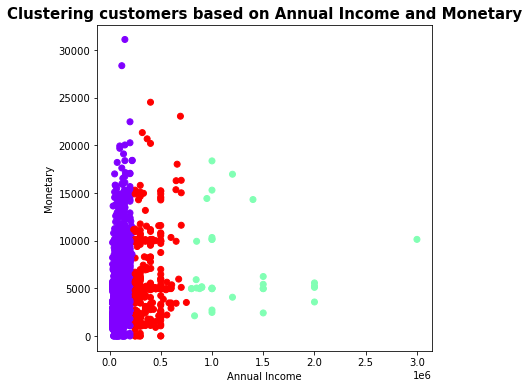

In [673]:
plt.figure(figsize=(6,6))
plt.scatter(new['Income'],new['Monetary'],c=new['cluster_pred'],cmap='rainbow')
plt.title("Clustering customers based on Annual Income and Monetary", fontsize=15,fontweight="bold")
plt.xlabel("Annual Income")
plt.ylabel("Monetary")

the lowe income earners are the most profitable to Business

In [674]:
#To compare attributes of the different clusters, lets find the average of all variables across each cluster
avg_data = new.groupby(['cluster_pred'], as_index=False).mean()
avg_data

cluster_pred        Age    Gender        Income  NoChildren  \
0             0  33.789821  0.242696  1.045529e+05    1.072573   
1             1  35.285714  0.171429  1.223017e+06    1.485714   
2             2  36.638695  0.193473  3.605040e+05    1.538462   

   TimeEmploymentMM  TotalTimeAtAddress  DayOfTheMonth    Recency  Frequency  \
0         67.289821          175.196984      16.019793  33.329406   1.232799   
1         80.685714          130.742857      16.628571  33.342857   1.371429   
2         78.613054          171.533800      16.261072  38.172494   1.230769   

      Monetary  
0  4399.099486  
1  7028.617714  
2  5687.234476

In [675]:
#see details of the clusters
new.groupby('cluster_pred')['AddresLGA'].describe()

count unique              top freq
cluster_pred                                   
0             2122    127         Alimosho  188
1               35     18          Ikorodu    4
2              429     71  Abuja Municipal   41

In [313]:
#filter accounts not disbursed to
jul = lite[~(lite['DisbMonth'].isna())]
lite = lite[lite['AccountState'].isin(['CLOSED'])]


lite = lite[['clientID', 'Age', 'EducationStatus', 'Gender', 'Income', 'MaritalStatus', 'TimeEmploymentMM', 'TotalTimeAtAddress']]
# Drop Duplicate information in the dataset

lite.drop_duplicates(subset ='clientID', keep = 'first', inplace = True)
# Encode for string labels


#filter neeeded fileds from rfm_table
rfm = rfm_table[['clientID', 'Recency', 'Frequency','Monetary']]

#merge
data = lite.merge(rfm, on='clientID', keep = 'first', inplace = True)
data.head()

clientID  Age EducationStatus  Gender    Income MaritalStatus  \
0  22255490492   25       Secondary    MALE   40000.0        Single   
1  22243090415   43        Graduate    MALE   40000.0       Married   
2  22159134290   24        Graduate  FEMALE  100000.0        Single   
3  22293284211   43        Graduate    MALE  150000.0        Single   
4  22245652590   45        Graduate    MALE  126000.0       Married   

   TimeEmploymentMM  TotalTimeAtAddress  Recency  Frequency  Monetary  
0                29               318.0       43          1   1303.00  
1               111               222.0       37          2   7052.00  
2                17               196.0       60          1   3316.00  
3               162               146.0       36          2  13971.98  
4                25                49.0       30          1   1966.00

In [315]:

#standardize
standard_normalized_vars(data[['Income', 'TimeEmploymentMM', 'TotalTimeAtAddress', 'Monetary', 'Recency']])
#convert categorical columns to numerical
data = pd.get_dummies(data)

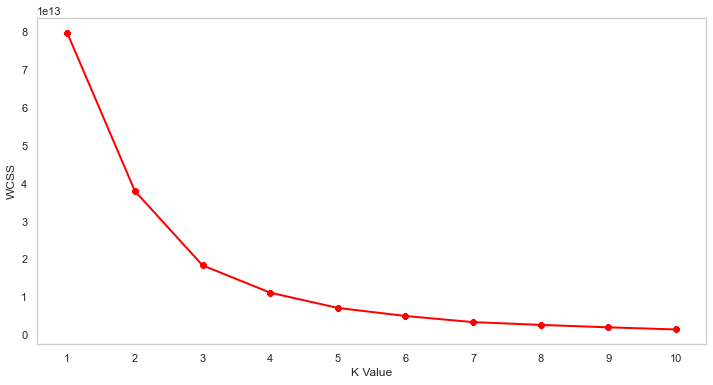

In [316]:
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(data.iloc[:,1:])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

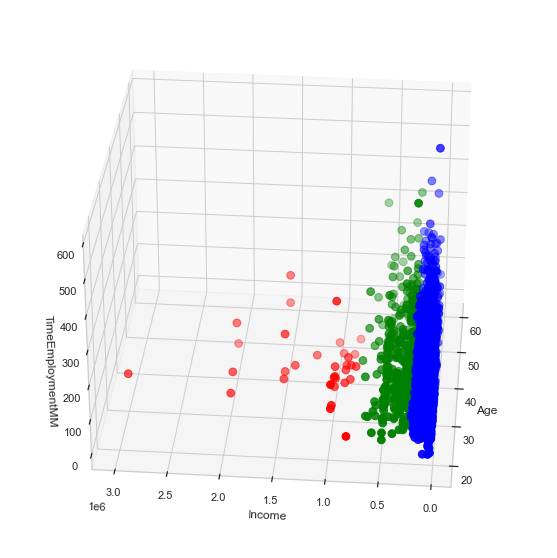

In [258]:
km = KMeans(n_clusters=3)
clusters = km.fit_predict(data.iloc[:,1:])
data["label"] = clusters

from mpl_toolkits.mplot3d import Axes3D

 
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data.Age[data.label == 0], data["Income"][data.label == 0], data["TimeEmploymentMM"][data.label == 0], c='blue', s=60)
ax.scatter(data.Age[data.label == 1], data["Income"][data.label == 1], data["TimeEmploymentMM"][data.label == 1], c='red', s=60)
ax.scatter(data.Age[data.label == 2], data["Income"][data.label == 2], data["TimeEmploymentMM"][data.label == 2], c='green', s=60)
#ax.scatter(data.Age[data.label == 3], data["Income"][data.label == 3], data["TimeEmploymentMM"][data.label == 3], c='orange', s=60)

ax.view_init(30, 185)
plt.xlabel("Age")
plt.ylabel("Income")
ax.set_zlabel('TimeEmploymentMM')
plt.show()

In [259]:
data.label.value_counts()

0    2167
2     433
1      33
Name: label, dtype: int64

In [907]:
data.groupby('cluster_pred')['Income'].describe()

KeyError: 'cluster_pred'

Let's tryy segmenting customers in a different way

## Profiling


**Champions**: Got a loan recently, often and spend the most

**Loyal customers**: Buy on a regular basis.

**Potential loyalist**: Recent customers with average frequency.

**New customers**: Bought most recently, but not often.

**Promising**: Recent customers, but haven’t spent much.

**Needs attention**: Above average recency, frequency and monetary values. May not have bought very recently though.

**About to sleep**: Below average recency and frequency. Will lose them if not reactivated.

**At risk**: Some time since they’ve purchased. Need to bring them back

**Can’t lose them**: Used to purchase frequently but haven’t returned for a long time.

**Hibernating**: Last purchase was long back and low number of orders. May be lost.

In [391]:
# Create human friendly RFM labels
segt_map = {
    r'[1-2][1-2][1-2]': 'Champions',
    r'[1-2][2-3][3-4]': 'Potential loyalists',
    r'[1-2]44': 'New Customers',
    r'[1-2][3-4][1-3]': 'Promising',
    r'[1-2][1-2][1-4]': 'Loyal Customers',
    r'3[1-4][1-3]': 'About to Churn(good)',
    r'3[1-4][4]': 'About to Churn',
    r'4[1-4][1-3]': 'Good Churned Customers',
    r'4[1-4]4': 'Least Profitable churned Customers'
}
rfm_table['Segment'] = rfm_table['R'].map(str) + rfm_table['F'].map(str) + rfm_table['M'].map(str)
rfm_table['Segment'] = rfm_table['Segment'].replace(segt_map, regex=True)


rfm_table.head()

clientID  Recency  Frequency  Monetary    T  RecencyCluster  \
0  22141758042       85          1    3374.0  116               0   
1  22142274105      123          1    3466.0  145               0   
2  22142501225       81          1    2762.0  137               0   
3  22143621326      120          1    2095.0  150               0   
4  22144775491      144          1    3399.0  149               0   

   FrequencyCluster  MonetaryCluster RecencyClusterTag FrequencyClusterTag  \
0                 0                0              >=79                   1   
1                 0                0              >=79                   1   
2                 0                0              >=79                   1   
3                 0                0              >=79                   1   
4                 0                0              >=79                   1   

  MonetaryClusterTag  Cluster Color  R  F  M RFMGroup  RFMScore  \
0             <=3659        0   red  4  4  3      443        11   
1             <=3659        0   red  4  4  3      443        11   
2             <=3659        0   red  4  4  3      443        11   
3             <=3659        0   red  4  4  3      443        11   
4             <=3659        0   red  4  4  3      443        11   

  RFM_Loyalty_Level                 Segment  
0            Bronze  Good Churned Customers  
1            Bronze  Good Churned Customers  
2            Bronze  Good Churned Customers  
3            Bronze  Good Churned Customers  
4            Bronze  Good Churned Customers

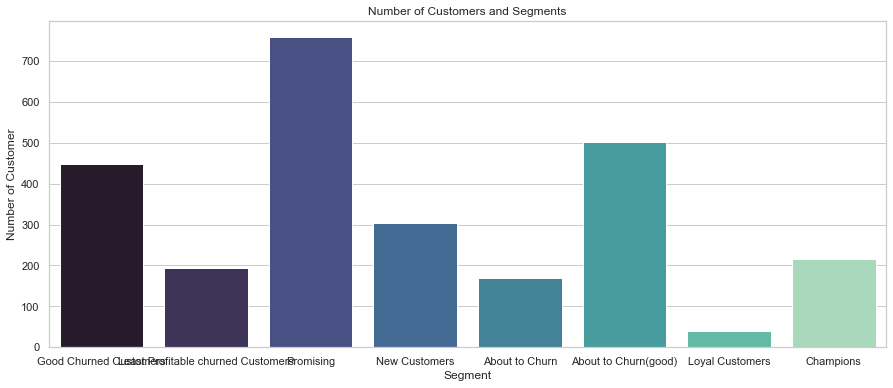

In [392]:
plt.figure(figsize=(15,6))
sns.countplot(x=rfm_table['Segment'], palette = 'mako')
plt.title('Number of Customers and Segments')
plt.xlabel('Segment')
plt.ylabel('Number of Customer')
plt.show()

In [393]:
summary_df = rfm_table.groupby('Segment').agg({
    'clientID': [ groupby_count],
    'Recency': [ groupby_mean],
    'Frequency': [groupby_mean],
    'Monetary' : [percentage, groupby_mean]
})

summary_df=summary_df.reset_index()
summary_df

Segment clientID    Recency Frequency  \
                                         count        avg       avg   
0                      About to Churn      170  50.617647  1.005882   
1                About to Churn(good)      501  51.319361  1.241517   
2                           Champions      215  16.962791  2.279070   
3              Good Churned Customers      448  94.906250  1.109375   
4  Least Profitable churned Customers      194  98.932990  1.015464   
5                     Loyal Customers       40  18.200000  2.175000   
6                       New Customers      305  19.232787  1.000000   
7                           Promising      760  17.439474  1.000000   

    Monetary               
  percentage          avg  
0        2.3  1538.562706  
1       23.7  5472.917325  
2       17.2  9245.296884  
3       18.6  4794.874375  
4        2.6  1525.576753  
5        1.1  3242.789000  
6        3.8  1454.061770  
7       30.8  4685.003974

In [295]:
summary_df

Segment clientID    Recency Frequency  \
                                         count        avg       avg   
0                      About to Churn      108  50.472222  2.129630   
1                          Chamipions      255  17.156863  2.262745   
2              Good Churned Customers       49  86.653061  2.061224   
3                         Hibernating      563  51.269982  1.000000   
4  Least Profitable churned Customers      593  96.905565  1.000000   
5                       New Customers     1065  17.953052  1.000000   

    Monetary               
  percentage          avg  
0       10.4  8471.203796  
1       24.0  8303.727020  
2        4.1  7394.794898  
3       23.7  3709.764174  
4       23.6  3510.490152  
5       45.4  3759.710667

In [296]:
# Dropping a level down
summary_df.columns = summary_df.columns.droplevel(0)
summary_df

count        avg       avg  percentage  \
0                      About to Churn    108  50.472222  2.129630        10.4   
1                          Chamipions    255  17.156863  2.262745        24.0   
2              Good Churned Customers     49  86.653061  2.061224         4.1   
3                         Hibernating    563  51.269982  1.000000        23.7   
4  Least Profitable churned Customers    593  96.905565  1.000000        23.6   
5                       New Customers   1065  17.953052  1.000000        45.4   

           avg  
0  8471.203796  
1  8303.727020  
2  7394.794898  
3  3709.764174  
4  3510.490152  
5  3759.710667

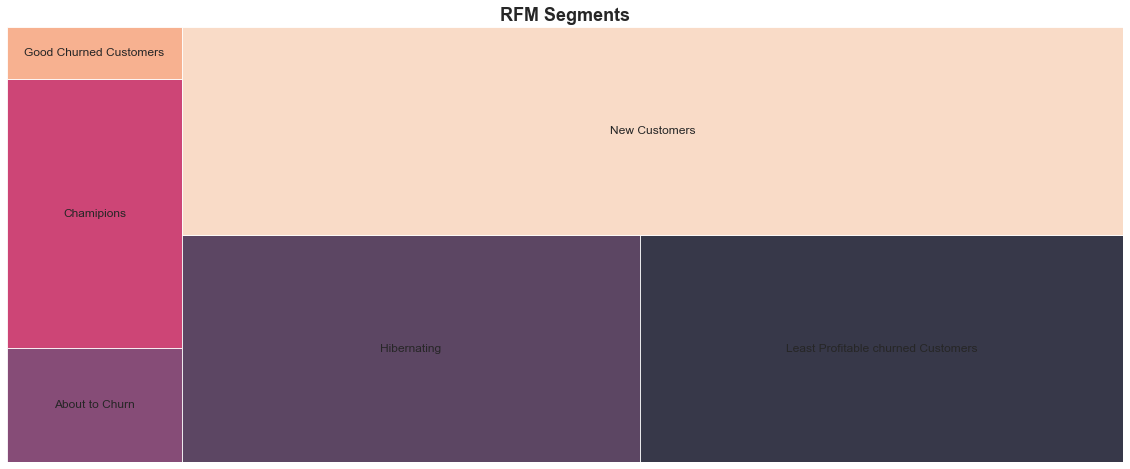

In [297]:
#Create our RFM Segment plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(20, 8)
squarify.plot(sizes=summary_df['count'], 
              label=summary_df[''].values, alpha=0.8 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

# Customer Lifetime Values
Using the **Beta-Geometric/Negative Binomial Distribution** a Buy-til-You-Die Model for predicting Customer Lifetime Value

In [103]:
# Install lifetimes
#!pip install lifetimes
!pip install lifetimes
!pip install openpyxl

  Using cached Lifetimes-0.11.3-py3-none-any.whl (584 kB)
  Using cached dill-0.3.4-py2.py3-none-any.whl (86 kB)
  Using cached autograd-1.3-py3-none-any.whl


In [1]:
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter

## preparing dataset to calculate CLV

In [3]:
import datetime as dt
latest_date = dt.datetime(2021, 9, 30)

clv = rfm_table[['clientID', 'Recency', 'Frequency', 'Monetary', 'T']]
clv.tail()

NameError: name 'rfm_table' is not defined

In [194]:
# in this case we will suppose that monetary value is average earning per transaction
clv['Monetary'] = clv['Monetary'] / clv['Frequency']

# transforming days to weeks
div = 7
clv['Recency'] = clv['Recency'] / div
clv['T'] = clv['T'] / div
clv.tail()

clientID   Recency  Frequency     Monetary          T
2654  22300266654  8.857143          3  2925.000000  14.714286
2655  22306062513  6.571429          3  4250.720000  22.857143
2656  22332880026  6.285714          3  3597.333333  23.142857
2658  22385887199  6.714286          3  4567.666667  17.714286
2659  22408493662  9.857143          3  5077.110000  19.285714

## Creating BG-NBD Model

In [195]:

bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(clv['Frequency'], clv['Recency'], clv['T'])

<lifetimes.BetaGeoFitter: fitted with 2633 subjects, a: 2.99, alpha: 18.51, b: 0.91, r: 3.73>

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

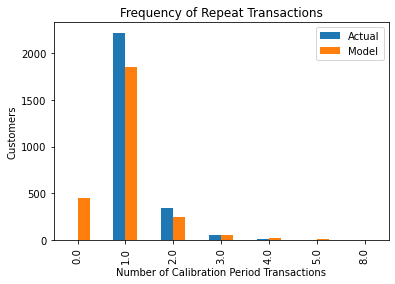

In [196]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [197]:
# Top 10 customers expected to make the most purchases in a week
bgf.conditional_expected_number_of_purchases_up_to_time(1, # week
                                                        clv['Frequency'],
                                                        clv['Recency'],
                                                        clv['T']).sort_values(ascending=False).head(10)

2302    0.066534
2214    0.060636
1574    0.051634
386     0.051634
525     0.050545
1470    0.049899
338     0.048823
2343    0.047841
1512    0.047531
363     0.047531
dtype: float64

In [198]:
# Top 10 customers expected to make the most purchases in a month
bgf.conditional_expected_number_of_purchases_up_to_time(4, # 4 weeks = 1 month
                                                        clv['Frequency'],
                                                        clv['Recency'],
                                                        clv['T']).sort_values(ascending=False).head(10)

2302    0.221293
2214    0.210549
386     0.163293
1574    0.163293
2343    0.162985
525     0.159605
2314    0.159448
1470    0.158042
338     0.154403
2332    0.153970
dtype: float64

In [190]:
# Top 10 customers expected to make the most purchases in next 6 months
bgf.conditional_expected_number_of_purchases_up_to_time(4 * 6, # weeks * count = months
                                                        clv['Frequency'],
                                                        clv['Recency'],
                                                        clv['T']).sort_values(ascending=False).head(10)

1204    1.939634
2363    1.534054
2589    1.487005
2369    1.454968
2366    1.430812
2342    1.418584
2602    1.361618
2604    1.359545
2204    1.351393
2265    1.348394
dtype: float64

In [199]:
# The count of total transactions expected in next 6 months
bgf.conditional_expected_number_of_purchases_up_to_time(4 * 6,
                                                        clv['Frequency'],
                                                        clv['Recency'],
                                                        clv['T']).sum()

414.0555854217395

## Gamma Gamma model for monetary value

The model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel, which relies upon an important assumption. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [200]:

rfm_table[['Monetary', 'Frequency']].corr()


Monetary  Frequency
Monetary   1.000000   0.566945
Frequency  0.566945   1.000000

the model won't be accurate since the 2 vectors isn't close to 0, but let's go ahead and confirm

In [202]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(clv['Frequency'], clv['Monetary'])

<lifetimes.GammaGammaFitter: fitted with 2633 subjects, p: 2.69, q: 0.17, v: 2.64>

In [203]:
# The top 10 customers expected to be most valuable
ggf.conditional_expected_average_profit(clv['Frequency'],
                                        clv['Monetary']).sort_values(ascending=False).head(10)

2397    22004.030739
2412    21551.036012
2439    21530.128118
2433    21058.999730
2401    20865.092383
2452    20838.101405
2435    20647.156129
2384    20299.062098
2438    19698.556184
2381    19520.253899
dtype: float64

## Predicting Customer lifetime value

In [211]:
# The customers' lifetime values expected to in the next 3 months
clv['clv_pred_1_months'] = ggf.customer_lifetime_value(bgf,
                                   clv['Frequency'],
                                   clv['Recency'],
                                   clv['T'],
                                   clv['Monetary'],
                                   time=1,  # 3 months
                                   freq="W"  # frequency information of T. In this case we set week by using 'W'
                                   )
clv

clientID    Recency  Frequency     Monetary          T  \
0     22141758042  12.142857          1  3374.000000  16.571429   
1     22142274105  17.571429          1  3466.000000  20.714286   
2     22142501225  11.571429          1  2762.000000  19.571429   
3     22143621326  17.142857          1  2095.000000  21.428571   
4     22144775491  20.571429          1  3399.000000  21.285714   
...           ...        ...        ...          ...        ...   
2654  22300266654   8.857143          3  2925.000000  14.714286   
2655  22306062513   6.571429          3  4250.720000  22.857143   
2656  22332880026   6.285714          3  3597.333333  23.142857   
2658  22385887199   6.714286          3  4567.666667  17.714286   
2659  22408493662   9.857143          3  5077.110000  19.285714   

      clv_pred_3_months  clv_pred_1_months  
0            690.428905         321.598340  
1            816.132114         370.208532  
2            353.091900         161.271459  
3            433.420040         195.792965  
4           1018.086451         460.286607  
...                 ...                ...  
2654        1040.773587         485.262961  
2655         206.338429          91.476865  
2656         154.268667          68.290900  
2658         581.314911         265.520016  
2659         991.958815         448.676913  

[2633 rows x 7 columns]

## comparing predicted 1 month clv with the actual

In [212]:
#get clientID from the august data
aug_id = rfm_aug.clientID.values

#get the clientIDs in aug data
aug = clv[clv['clientID'].isin(aug_id)]

#abut 214 customers returned for a loan in august, the rest were new customers

#merge 
test = aug.merge(rfm_aug, on='clientID')
test.head()

clientID    Recency  Frequency_x  Monetary_x          T  \
0  22173411072  11.571429            1      3055.0  15.857143   
1  22177238237  11.428571            1      2462.0  12.142857   
2  22186056611  13.428571            1      2746.0  18.571429   
3  22194129626  11.571429            1      3646.0  14.571429   
4  22281385861  16.857143            1      2026.0  20.142857   

   clv_pred_3_months  clv_pred_1_months  Frequency_y  Monetary_y  
0         637.062776         298.242917            1     2086.00  
1         838.420787         404.056344            1     3496.00  
2         513.264248         235.904463            1     2554.00  
3         904.996317         427.718483            1     5032.67  
4         471.561853         214.634539            1    12372.24

Comparing the predicted values with the actual , we can see the model is inaccurate